## CQF Final Report ##
### Algorithmic Trading for Mean-Reversion and Trend-Following ###
As financial markets have grown in complexity and scale, the need for more sophisticated trading methods has become increasingly apparent. Traditional manual trading, where decisions are made and executed by human traders, is often limited by speed, personal biases, and the sheer volume of market data that needs to be processed. Algorithmic trading addresses these challenges by automating the trading process, where trading decisions and executions are carried out by pre-programmed algorithms rather than human intervention. 

Specifically, the use of algorithmic trading has surged across various financial markets, including equities, virtual currency, commodities, and derivatives. This approach leverages mathematical models, statistical analysis, and computation to identify and capitalize on trading signals, hence enabling more efficient and profitable trades. By this way, it largely eliminates human errors and individual biases in trading decision process. The overall objective of the algorithmic trading is to execute trades at the most optimal price, minimize transaction costs, and reduce risk effectively, all while taking advantage of market changes that may only exist for brief moments. More importantly, algorithmic trading can process and act on vast amount of market data in just milliseconds, much faster than a human trader could do. 

However, algorithmic trading is not like human trading - it greatly relies on historical data and techinical indicators to predict future market movements. Human traders can sometimes make intuitive trading decisions based on their own experience and market sentiment, which algorithms may not fully replicate. As a result, it might lack human judgement in real-time trading. Additionally, algorithmic trading can be highly sensitive to market volatility. Unexpected and unforseened market movements can sometimes lead to significant losses if the algorithms are not designed to handle such situations effectively. Therefore, an effective trading strategy is quite crucial in a rapidly-changing markets, further allowing traders to capture minor price changes, identify signals, execute market order, and eventually make profit. In general, this report will explore on the application of mean-reversion, trend following, and rising_callback trading strategies. 

### Approach ###
Below is a table of the numerical approaches.

| Technique                | Description                                                                 |
|--------------------------|-----------------------------------------------------------------------------|
| Kalman Filtering         | Utilize Kalman Filtering to smooth out the impact of sentiment |
| Technical Indicators     | Codes technical indicators like exponential moving averages, RSI, ADX, MACD, Stochastic to generate signals and guide trading decisions based on price trends and momentum. |
| Mean-Reversion           | Use filtered data as signals. Identifies securities that have deviated from their historical average and they will revert back to average. |
| Trend-Following          | Use indicators to generate signals. Identifies and follows the direction of the market trend to make trading decisions. |
| Rising Callback          | Utilizes callback functions to execute trades based on RSI and ADX indicators |
| Mathematical Models      | Uses mathematical models to predict market movements and optimize trading strategies. |
| Real-Time Trading        | Converts backtesting strategies to real-time trading. Use Alpaca API to submit or cancel orders |

### API & Functions ###
#### Tools & Broker API ####
To implement the algorithmic trading strategies, the report includes **Python** code and utilizes **Alpaca REST API** as the broker API. Specifically, we have used the **Alpaca-py** (Python SDKs) to access Alpaca API. Generally, Alpaca offers a powerful and user-friendly REST API that enables us to execute trading strategies programmatically. And it provoide us with tools to fetch historical market and manage the trading process effectively. It further offers commission-free trading, which effectively minimize the trading costs. For safety reasons, this report executed all the code and strategies in the paper trading account that Alpaca provides.

Then, for the real-time data analysis, the Alpaca API provides streams of price quotes, trade information, and other market data through **WebSockets**. I import some of the key libraries and python packages used for the algorithmic trading program (File Requirement.txt). These libraries provide the necessary tools and functionalities to efficiently fetch market historical data, execute trading strategies, perform market data analysis, and create visualizations of trading backtestings. 
<!-- set up of the libraries -->

In [18]:
### importing libraries
import requests
import os
import json
### importing data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
### import alpaca_trade_api and API
import alpaca_trade_api as tradeapi
from alpaca_trade_api.rest import REST, TimeFrame
from alpaca.data import CryptoHistoricalDataClient, StockHistoricalDataClient, OptionHistoricalDataClient
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest, StockBarsRequest, OptionBarsRequest
import websocket
from datetime import datetime, date, timedelta
import time
from datetime import datetime, date, timedelta

# setting up the environment and endpoint
os.chdir("/Users/yujiuqiao/Desktop/Algorithmic-Trading/alpaca")
endpoint = 'https://data.alpaca.markets'
headers = json.loads(open('keys.txt', 'r').read())
# Alpaca API key ID and secret key
api = REST(headers["APCA-API-KEY-ID"], headers["APCA-API-SECRET-KEY"], base_url=endpoint)

The above code sets up the environment for the algorithmic trading program. Mainly, we import some key libraries for HTTP requests, real-time data streaming, and the Alpaca Broker API. Then, we defines the main API endpoint URL, and reads the API keys from the "keys.txt" file. Using the key ID and secret key, we autenticate the Alpaca API client services and then request the responses in JSON format. And to verify that we have successfully set up the trading account, we use the `get_account` function to retrieve key informations of user trading account, including account number, buying power, cash, portfolio value, equity, etc.

In [ ]:
# get account information
def get_account():
    # endpoint setting
    endpoint = 'https://paper-api.alpaca.markets'
    acc_url = endpoint + "/v2/account"
    response = requests.get(acc_url, headers=headers)
    return response.json() # return account information

get_account()

#### Market Data API ####
<!-- historical data api content -->
For algorithmic trading, market data is the most important quantitative factor that describes the entire market movement. Especially in a volatile market, where stock prices fluctuate greatly, we can always use real-time market data to monitor our positions, make decisions, and accordingly adjust our strategies based on current market conditions. Without them, trading algorithms are rendered as impractical, ineffective and incomplete. Naturally, access to accurate and timely market data is the foundation of algorithmic trading. And in this case, Alpaca provides market historical data APIs through HTTP protocols, hence allowing us to effectively develop, backtest, and execute our trading strategies with great precisions.

In [ ]:
# retrieve historical data
def hist_data(symbols, timeframe, limit, start, end, after, until):
    df_data = {}
    # endpoint setting  
    bar_url = "https://data.alpaca.markets/v2/stocks/bars"
    params = {
        'symbols': symbols,
        'timeframe': timeframe,
        'limit': limit,
        'start': start,
        'end': end,
        'after': after,
        'until': until,
    }
    response = requests.get(bar_url, headers=headers, params=params)
    json_dump = response.json()

    # check if bars is in the response data
    if 'bars' not in json_dump:
        raise KeyError("'bars' not found in the response data")
    
    df_data = {}
    for symbol in json_dump['bars']:
        temp = json_dump['bars'][symbol]
        df = pd.DataFrame.from_records(temp)
        df.rename({'t': 'time', 'o': 'open', 'h': 'high', 'l': 'low', 'c': 'close', 'v': 'volume'}, axis=1, inplace=True)
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
        df.index = df.index.tz_convert('America/New_York')
        df_data[symbol] = df   
    return df_data

# get historical ticker bar data
def hist_data(symbols, start_date ="2024-06-01", timeframe="Minute"):
    df_data = {}
    api = REST(headers["APCA-API-KEY-ID"], headers["APCA-API-SECRET-KEY"], base_url=endpoint)
    for ticker in symbols:
        if timeframe == "Minute":
            df_data[ticker] = api.get_bars(ticker, "15Min", start_date, adjustment='all').df # retrieving 15 Minute bars
        elif timeframe == "Hour":
            df_data[ticker] = api.get_bars(ticker, TimeFrame.Hour, start_date, adjustment='all').df # retrieving Hour bars
        else:
            df_data[ticker] = api.get_bars(ticker, TimeFrame.Day, start_date, adjustment='all').df
    return df_data

data = hist_data(['AAPL'], '2024-04-01', 'Minute')
pd.DataFrame(data['AAPL'])

In the `hist_data` function, we passed the parameters of symbols for tickers, starting time, end time, and expected timeframes. The retrieved historical data will be returned as a pandas dataframe, with the data of time, trading volume, tickers' open, high, low, close, volume weighted average prices. In this report, we apply a relatively high frequency and use 15-minute timeframed historical data for strategy backtest. And the returned historical data is in the format of, (example of AAPL market data)

| Timestamp | close | high | low | trade_count | open | volume | vwap |
|-----------|-------|------|-----|-------------|------|--------|------|
| 2024-04-01 08:00:00+00:00  | 171.2400  | 171.59  | 170.990  | 339  | 171.59 | 8127 | 171.263577 |
| 2024-04-01 08:15:00+00:00  |	171.2800 | 171.34  | 171.2800 |	103	 | 171.33 | 3360 | 171.313030 |
| 2024-04-01 08:30:00+00:00	 | 171.2700	 | 171.29  | 171.2700 | 74	 | 171.29 |	1721 | 171.289471 |
| ... | ...	| ... | ... | ... |	... | ... |	... |
| 2024-08-16 23:00:00+00:00  | 225.9795  | 226.02  | 225.9400 | 115  | 226.02 | 8569  | 225.982934 |
| 2024-08-16 23:15:00+00:00  | 225.8800  | 225.98  | 225.8800 | 65   | 225.98 | 3411  | 225.932700 |
| 2024-08-16 23:30:00+00:00  | 225.8400  | 225.90  | 225.6000 | 101  | 225.88 | 5632  | 225.872720 |

Due to limitation of trading account, the data source of market data is IEX (Investors Exchange LLC). The IEX accounts for only $2.5 \%$ of the market volume. And to some extent, the insights and results derived from the fetched data might not fully represent the broader market trends.

Further, to acquire information of tickers' latest trade and latest quote. We have implemented the `last_trade` and `last_quote` functions. Using these functions, we are able to fetch the most recent trade and quote data to assist us for decision-making.

In [20]:
# get the latest trade of tickers
def last_trade(symbol):
    last_trade_url = "https://data.alpaca.markets/v2/stocks/trades/latest"
    params = {
        'symbols': symbol
    }
    response = requests.get(last_trade_url, headers=headers, params=params)
    json_dump = response.json()
    # get the price and size of the latest trade
    return json_dump["trades"][symbol]["p"], json_dump["trades"][symbol]["s"]

# get the latest quote of tickers
def last_quote(symbol):
    last_quote_url = "https://data.alpaca.markets/v2/stocks/quotes/latest"
    params = {
        'symbols': symbol
    }
    response = requests.get(last_quote_url, headers=headers, params=params)
    json_dump = response.json()
    # get the ask price, ask size, bid price, bid size
    return json_dump["quotes"][symbol]["ap"], json_dump["quotes"][symbol]["as"], json_dump["quotes"][symbol]["bp"], json_dump["quotes"][symbol]["bs"]

These two functions effectively retrieve tickers' latest trade and quote information, including the ask price, ask size, bid price, and bid size. We can further use these two functions to check tickers' data while trading. 

Also, Alpaca API provides the **WebSocket** stream for real-time market data. WebSockets allows for continuous data streaming, ensuring that we have instant access to the latest market information. Such real-time data flow is critical for executing trading strategies that depend on rapid responses to market changes. Specifically, we write code to connect to Alpaca's market data stream via WebSocket, subscribes to specified stock symbols for trade and quote data. Further, we store the retrieved data in the SQLite database; SQLite database is quite suitable to handle large volumes of market data. We then resample data every $1$ minute, and apply the data in the trading. 

By systematically saving market data in a structured database, we can have quick access to essential information for backtesting, strategy development, and most importantly, query data to make live trading decisions. As a result, we can use WebSockets to reduce latency, and enhance algorithm's efficiency.

In [21]:
# import libraries
import sqlite3
import dateutil.parser

endpoint = "wss://stream.data.alpaca.markets/v2/iex"
headers = json.loads(open("keys.txt", "r").read())

# trade and quote tickers
trade_tickers = ["AAPL", "TSLA", "GOOG", "AMZN"]
quote_tickers = ["AAPL", "TSLA", "GOOG", "AMZN","META"]

# connect to the database
db1 = sqlite3.connect("trades_ticks.db")
db2 = sqlite3.connect("quotes_ticks.db")

To store the market data in the SQLite database, we first have to creat database, if not exist, using the function `create_tables`. For the latest trade table, it uses the timestamp as the primary key, and stores tickers' latest price and volume. Latest prices, in this case, is the price at which the most recent trade was executed. With latest prices, we can easily track price movements and making decisions about entry and exit points in trading strategies. Additionally, the latest volume informs us about market liquidity, and potentialy how strong the trend is. These data all helps with the trading strategies.

And for the latest quotes table, the database stores bid price, ask price, bid volume, and ask volume. The bid price is the highest price that a buyer is willing to pay for the equity at a given time; and the ask price is the the lowest price at which a seller is willing to sell the equity. With all these information, we can know market sentiment and further make trades.

In [65]:
# create sql tables
def create_tables(db, tickers, tick_type):
    c = db.cursor()
    if tick_type == "trades":
        for ticker in tickers:
            c.execute("CREATE TABLE IF NOT EXISTS {} (timestamp datetime primary key, price real(15,5), volume integer)".format(ticker))
    if tick_type == "quotes":
        for ticker in tickers:
            c.execute("CREATE TABLE IF NOT EXISTS {} (timestamp datetime primary key, bid_price real(15,5), ask_price real(15,5), bid_volume integer, ask_volume integer)".format(ticker))
    try:
        db.commit()
    except:
        db.rollback()

create_tables(db1,trade_tickers,"trades")
create_tables(db2,quote_tickers,"quotes")

Then, after creating SQLite database, we need to insert tickers' data into the database when we retrieve real-time data stream via WebSocket. Below, the function `insert_ticks` allow us to insert latest quote / trade data into the database.

In [66]:
# insert ticks into the tables
def insert_ticks(tick):
    # insert ticks' quotes data
    if tick[0]["T"] == "q":
        c = db2.cursor()
        for ms in range(1000):
            try:        
                tabl = tick[0]["S"]
                vals = [dateutil.parser.isoparse(tick[0]["t"])+datetime.timedelta(microseconds=ms),tick[0]["bp"],tick[0]["ap"],tick[0]["bs"],tick[0]["as"]]
                query = "INSERT INTO {}(timestamp,bid_price,ask_price,bid_volume,ask_volume) VALUES (?,?,?,?,?)".format(tabl)
                c.execute(query,vals)
                break
            except Exception as e: print(e)
        try: db2.commit()
        except: db2.rollback()
    
    # insert ticks trade data
    if tick[0]["T"] == "t":
        c = db1.cursor()
        for ms in range(1000):
            try:        
                tabl = tick[0]["S"]
                vals = [dateutil.parser.isoparse(tick[0]["t"])+datetime.timedelta(microseconds=ms),tick[0]["p"],tick[0]["s"]]
                query = "INSERT INTO {}(timestamp,price,volume) VALUES (?,?,?)".format(tabl) # insert into the table
                c.execute(query,vals)
                break
            except Exception as e: print(e)
        try: db1.commit()
        except: db1.rollback()

When we fetch the data and store it in the SQLite database, we need to convert it to a pandas dataframe that is suitable for data analysis and trading algorithm development. Therefore, we design `get_bars` function to convert the database to the open, high, low, close historical data candle bars, the same as what we obtain through historical data API. 

In [22]:
# convert sql data to pandas dataframe
# fetch data from sql tables
def get_bars(db, ticker):
    data = pd.read_sql("SELECT * FROM {}".format(ticker), con=db)
    data.set_index(['timestamp'], inplace=True)
    data.index = pd.to_datetime(data.index)
    price_ohlc = data['price'].resample('1Min').ohlc().dropna()
    price_ohlc.columns = ['open', 'high', 'low', 'close']
    vol_ohlc = data['volume'].resample('1Min').apply({'volume':'sum'}).dropna()
    df = price_ohlc.merge(vol_ohlc, left_index=True, right_index=True)
    return df

Lastly, we write WebSocket Event handlers functions to connect to Alpaca data streaming service. This enables us to get real-time market data, and better execute our trading strategies. For the retrieved data, we mainly focus on "s" (symbol), "p" (price), "q" (quantity), and "T" (trade time). Overall, by leveraging WebSocket, we make sure that our strategies work on most recent data.

In [ ]:
# Event handler
# Called when the WebSocket connection is opened. 
# Sends authentication and subscription messages
def on_open(ws):
    # WebSocket streaming authentication
    auth_data = {
        "action": "auth",
        "key": headers["APCA-API-KEY-ID"],
        "secret": headers["APCA-API-SECRET-KEY"],
    }
    ws.send(json.dumps(auth_data))
    message = {
        "action": "subscribe",
        "trades": trade_tickers,
        "quotes": quote_tickers,
    }
    ws.send(json.dumps(message))

# when a message is received. Parses the message and inserts it into the database.
def on_message(ws, message):
    print(message)
    data = json.loads(message)
    insert_ticks(data)

# error messages
def on_error(ws, error):
    print("Error encountered:", error)

def on_close(ws, close_status_code, close_msg):
    print("WebSocket closed with code:", close_status_code, "and message:", close_msg)

# market data streaming
ws = websocket.WebSocketApp("wss://stream.data.alpaca.markets/v2/iex", on_open=on_open, on_message=on_message, on_error=on_error, on_close=on_close)
ws.run_forever()

#### Trading API ####
Aside from obtaining market data, the core functionality of any algorithmic trading system lies in its ability to effectively execute trades. We have to submit or cancel order to get stocks traded. By leveraging Alpaca Trade API, we are able to monitor, place, and cancel orders. More importantly, with trade API, we can automate the execution of our trading strategies. And even under volatile market, we can use the trade API to capture minor yet profitable moments and execute trades efficiently. Furthermore, the Alpaca Trade API enhances the scalability of trading systems. As trading strategies grow in complexity and the number of trades increases, it becomes increasingly impractical to manually trade. If we do manually trade, we might easily miss the profitable moments when we encounter multiple profitable trading signals. And this API allows us to scale our trade, concurrently managing multiple stock orders.

One of the most important functions are `positions` and `order_list`. The `positions` fuction is designed to return us the position of certain tickers, so that we track whether our orders are filled or not. We can further use Alpaca Order API to track the status of partially filled, filled, or canceled orders. And in dynamic market, knowing the status of every orders is crucial, we can accordingly adjust our positions by replacing or even canceling orders.

In [ ]:
# get positions of certian symbols
def positions(symbol = ""):
    endpoint = 'https://paper-api.alpaca.markets'
    if len(symbol) > 1:
        pos_url = endpoint + f"/v2/positions/{symbol}"
    else:
        pos_url = endpoint + "/v2/positions"
    response = requests.get(pos_url, headers=headers)
    # positions["symbol"][] is a string! not a float
    return response.json()

# get order list
def order_list(status, limit):
    endpoint = 'https://paper-api.alpaca.markets'
    ord_list_url = endpoint + "/v2/orders"
    params = {
        'status': status,
        'limit': limit,
    }
    response = requests.get(ord_list_url, headers=headers, params = params)
    data = response.json()
    return pd.DataFrame(data)

# Example use of order_list function
order_df = order_list('close', 100)
order_df[order_df["symbol"] == "META"] # return all closed orders of META

In our strategies, everytime when we want to place orders, we first check the positions of that stock. If no position exists, we can then proceed with the orders. We can also use the object tradeapi's `get_position` function from Alpaca-py to retrieve the current positions.

In [ ]:
api = tradeapi.REST(headers["APCA-API-KEY-ID"], headers["APCA-API-SECRET-KEY"], base_url='https://paper-api.alpaca.markets')
# example usage of get_position function
try: api.get_position(symbol="AAPL") # get positions of certain stocks
except: print("No position found for stocks")

Moreover, one of the advantage of the Alpaca trading API is that, the API supports a wide range of order types, including market, limit, stop, and stop-limit orders. This versatility allows us to tailor our order execution, incorporate in our trading strategies, and further optimize our profit (meanwhile reducing risks and losses). 

In our strategies, we include market order, limit order, stop order, and trailing stop order, etc. Different order types are used when encountering different trading signals. To be specific, when we encounter a buying / selling signal, we would place a market order to buy / sell certain quantity of stocks using `market_order` function. Or we can call `submit_order` function in Alpaca-py to place our order. A market order in Alpaca is immediately executed at the current stock price. We can place market order to entry or exit the market quickly. However, the potential problem of market order is slippage, where the execution price is different from what we would expect. Another commonly used order type is the trailing stop loss order / stop loss order. When placing buy market order, we would at the same time place a trailing stop loss order / stop loss order on Alpaca (using `stop_order` / `trailing_stop_order`). A trailing stop order is a dynamic order that adjusts the stop price at a fixed percentage or dollar amount away from the market price. When the stock price reaches the stop price, the trailing stop loss order is triggered and stocks are sold. The trailing stop loss order can optimize our gains and meanwhile prevent us from huge loss. Lastly, the limit order allows us to buy or sell certain stocks at specific prices. For example, a buy limit order (`limit_order`) enables us to buy certain stocks at specified prices or even lower; and vice versa for sell limit order. Generally, all these types of orders are utilized under certain market conditions to maximize our profits (limit our risks).

In [ ]:
# market order
def market_order(symbol, quantity, side, timeinforce):
    endpoint = 'https://paper-api.alpaca.markets'
    ord_url = endpoint + "/v2/orders"
    params = {
        'symbol': symbol,
        'qty': quantity,
        'side': side,
        'type': 'market',
        'time_in_force': timeinforce,
    }
    response = requests.post(ord_url, headers=headers, json=params)
    return response.json()

# limit order
def limit_order(symbol, quantity, side, timeinforce, limit_price):
    endpoint = 'https://paper-api.alpaca.markets'
    ord_url = endpoint + "/v2/orders"
    params = {
        'symbol': symbol,
        'qty': quantity,
        'side': side,
        'type': 'limit',
        'time_in_force': timeinforce,
        'limit_price': limit_price,
    }
    response = requests.post(ord_url, headers=headers, json=params)
    return response.json()

# stop order
def stop_order(symbol, quantity, side, timeinforce, stop_price):
    endpoint = 'https://paper-api.alpaca.markets'
    ord_url = endpoint + "/v2/orders"
    params = {
        'symbol': symbol,
        'qty': quantity,
        'side': side,
        'type': 'stop',
        'time_in_force': timeinforce,
        'stop_price': stop_price,
    }
    response = requests.post(ord_url, headers=headers, json=params)
    return response.json()

# trailing stop order
def trailing_stop_order(symbol, quantity, side, timeinforce, trail_price):
    endpoint = 'https://paper-api.alpaca.markets'
    ord_url = endpoint + "/v2/orders"
    params = {
        'symbol': symbol,
        'qty': quantity,
        'side': side,
        'type': 'trailing_stop',
        'time_in_force': timeinforce,
        'trail_price': trail_price,
    }
    response = requests.post(ord_url, headers=headers, json=params)
    return response.json()

For more use of Order API, I include functions in the `alpaca_api.py` and use them in the strategies. There are stop limit order, bracket order functions.  

In [ ]:
# stop limit order
def stop_limit_order(symbol, quantity, side, timeinforce, limit_price, stop_price):
    endpoint = 'https://paper-api.alpaca.markets'
    ord_url = endpoint + "/v2/orders"
    params = {'symbol': symbol,
        'qty': quantity,
        'side': side,
        'type': 'stop_limit',
        'time_in_force': timeinforce,
        'stop_price': stop_price,
        'limit_price': limit_price,}
    response = requests.post(ord_url, headers=headers, json=params)
    return response.json()

# bracket order
def bracket_order(symbol, quantity, side, timeinforce, take_profit_limit_price, stop_price, stop_loss_limit_price):
    endpoint = 'https://paper-api.alpaca.markets'
    ord_url = endpoint + "/v2/orders"
    # take_profit_limit_price must be greater than base price + 0.01
    params = {'symbol': symbol,
        'qty': quantity,
        'side': side,
        'type': 'market',
        'time_in_force': timeinforce,
        "order_class": "bracket",
        "take_profit": {"limit_price": take_profit_limit_price},
        "stop_loss": {"stop_price": stop_price,
                      "limit_price": stop_loss_limit_price}}
    response = requests.post(ord_url, headers=headers, json=params)
    return response.json()

Meanwhile, we can use the `order_replace` function to replace any orders we made. And if the profitable market prices are no longer available, we include the `order_cancel` function to cancel any orders that have not been executed. Other usable functions, like delete positions, are also included in the `alpaca_api.py` code.

In [ ]:
# cancel order
def order_cancel(order_id):
    if (len(order_id) <= 0): # exception handling
        raise ValueError("order_id cannot be empty")
    else:
        endpoint = 'https://paper-api.alpaca.markets'
        ord_cancel_url = endpoint + f"/v2/orders/{order_id}"
    # cancel the most recent order
    response = requests.delete(ord_cancel_url, headers=headers)
    return response.text # return null

In conclusion, by referencing the Alpaca API, WebSocket services, and leveraging the coded functions, we have established a robust system for obtaining up-to-date market data and performing comprehensive market analysis. This lays good foundation for the development and refinement of our trading strategies, ensuring that our strategies work with most recent data. Furthermore, the trading API provides us with powerful tools to implement our trading strategies and automatically trade on Alpaca paper trade account. With all other kind of API that Alpaca provides, we can continually optimize our trading strategies.

### Trading Strategies ###
#### Mean-Reversion Strategy ####
We first implemented the **Mean-Reversion** trading strategies. Mean-reversion strategy is a fundamental trading approaches based on the principle that asset prices tend to revert to their historical average or mean over time. This strategy capitalizes on the temporary deviations of an asset's price from its equilibrium level, with the expectation that the price will eventually return to its mean. 

##### Kalman Filtering #####
Financial market is usually volatile and inherently noisy, with market prices affected by news factors and other market sentiment. Such noise can somehow obscure the underlying trends, and further prevent us from making accurate trading decisions. Therefore, we decided to integrate the Kalman Filter method in the mean-reversion strategy to remove the impact of noises. Overall, the Kalman Filter is a recursive algorithm that provides an optimal estimate of the true state of a dynamic system (in this case, the stocks close price) based on noisy observations. It help in modelling market impact by estimating the relationship between trade volume and price movements. The use of Kalman Filtering can effectively improve the accuracy of price and mean estimates, further generating high-quality trading signals. Ultimately, we can develop a much more robust trading model and hence profitable trading decisions.

Essentially, the Kalman filtering can be expressed as:
$$ 
\hat{x}_{k|k-1} = A \hat{x}_{k-1|k-1} + B u_k \\
P_{k|k-1} = A P_{k-1|k-1} A^T + Q
$$
where the first equation is the state prediction equation, and the second equation is the covariance prediction equation. In the equations, 
- $\hat{x}_{k|k-1}$ is the predicted value of the stock price at time $k$.
- $A$ is the state transition matrix, specifically how the $\hat{x}_{k|k-1}$ is changed to new state.
- $\hat{x}_{k-1|k-1}$ is the last estimated stock prices from the previous time step.
- $B u_k$ is any market factors that may impact the stock price.
- $P_{k|k-1}$ is predicted estimate covariance, the uncertainty in predicting $\hat{x}_{k|k-1}$.
- $P_{k-1|k-1}$ is the last time step estimate covariance
- $Q$ is the noise covariance matrix, randomness in stock price movements.

Then, we need to calculate Kalmain Gain, which is:
$$
K_k = P_{k|k-1} H^T (H P_{k|k-1} H^T + R)^{-1}
$$
where,
- $K_k$ is the Kalmain gain, the weights of observed price over predicted one.
- $H$ is the observation matrix, in this case, is 1
- $R$ is the measurement noise covariance, the uncertainty in stock prices, like market noise, news.

for the status update, we can update the predicted stock price based on the actual observed price:
$$
\hat{x}_{k|k} = \hat{x}_{k|k-1} + K_k(z_k - H \hat{x}_{k|k-1})
$$
The symbols in the equation represent:
- $\hat{x}_{k|k}$ is the updated stock price.
- $z_k$ is the observed stock price at time $k$.

And we can also update the covariance by the equation $P_{k|k} = (I - K_k H) P_{k|k-1}$. To implement the kalman filtering of stock prices, I write the function `kalman_filter` to smooth and filter the stock close prices.

In [43]:
# kalman filter function
# data is the historical market data close columns
def kalman_filter(data): 
    length = len(data)
    filter_data = np.zeros(length)  # State estimate
    P = np.zeros(length)  # Estimate covariance
    Q = 1e-5        # Process noise covariance
    R = 1e-2        # Measurement noise covariance
    K = np.zeros(length)  # Kalman Gain
    filter_data[0] = data[0]
    P[0] = 1.0

    for k in range(1, length): # iteratively
        filter_data[k] = filter_data[k-1] # State prediction
        P[k] = P[k-1] + Q # covariance prediction
        K[k] = P[k] / (P[k] + R) # Kalman Gain
        filter_data[k] = filter_data[k] + K[k] * (data[k] - filter_data[k]) # status update
        P[k] = (1 - K[k]) * P[k] # covariance update
    return filter_data

Specifically, when reading the 15-Minute market data using Alpaca's Market API, I add a column "kal" that writes the filtered close prices. We purposedly set the parameter $R$, the measurement noise covariance as $1e-2$. In this case, a lower $R$ value implies that the Kalman filter puts more weight on observed price data. We want to make sure that the filtered data still accurately corresponds to underlying trends, and reacts reasonably well to market movements.

In [41]:
#extract and store historical data in dataframe
tickers = ['AMZN', 'AAPL', 'GOOG', 'TSLA']
historicalData = hist_data(tickers, start_date ="2024-01-01", timeframe="Minute") 
for ticker in tickers:
    historicalData[ticker]["kal"] = kalman_filter(historicalData[ticker]["close"].values)

def kalman(tickers, df):
    for ticker in tickers:
        df[ticker]["kal"] = kalman_filter(df[ticker]["close"].values)
    return df

To better view the results of the kalman filtering, we plot the AAPL's stock close prices, and the filtered one. We shall see that the kalman filter smooth the close prices at certain extreme points (points with great price changes), and hence limit the impact of randomness. 

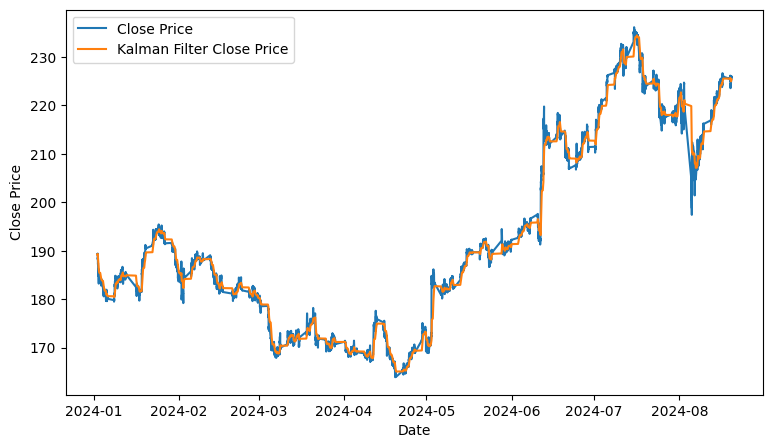

In [42]:
plt.figure(figsize=(9, 5))
plt.plot(historicalData["AAPL"]["close"], label="Close Price")
plt.plot(historicalData["AAPL"]["kal"], label="Kalman Filter Close Price")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()

##### Technical Indicators #####
Aside from Kalman filtering technique, we also apply several indicators to generate trading signals, like long-entry point, short-entry point. The use of indicators can assist us for making trading decisions. For the mean-reversion strategy, I mainly incorporate the momentum indicator Relative Strength Index (RSI), along with the trend strength indicator Average Directional Index (ADX).

> **Relative Strength Index**

To be specific, the **Relative Strength Index RSI** is a momentum oscillator that measures the speed and change of price movements. Its value takes between 0 and 100. In our strategy, we apply RSI to identify overbought or oversold conditions. And here is the step of how we calculate RSI.
First we calculate the price change,
$$
\text {Price Change} = \text{Current Close} - \text{Previous Close}
$$
Then, based on price change, we could get all positive and negative price changes, namely Gain and Loss. Over the 14 day period, we could calculate the average gain and loss. Instead of using the traditional method of averaging gains and losses, I deploy the Exponential Moving Average (EMA). The use of EMA makes the RSI more sensitive to recent price movements, which can help in capturing underlying trends or reversals more quickly.
$$
\text{EMA}(\text{Gain})_t = \alpha \times \text{Gain}_t + (1 - \alpha) \times \text{EMA}({Gain})_{t-1} \\
\text{EMA}(\text{Loss})_t = \alpha \times \text{Loss}_t + (1 - \alpha) \times \text{EMA}({Loss})_{t-1}
$$
with the smoothing factor,
$$\alpha = \frac{2}{\text{span} + 1}$$

And we implement the `EMA` function that takes the input of time span and historical data to calculate the exponential moving average of close price.

In [44]:
# function to calculate Exponential Moving Average (EMA)
# span = window size, take 20 days
def EMA(df_dict, span):
    for df in df_dict:
        df_dict[df]["ema"] = df_dict[df]["close"].ewm(span=span, adjust=False).mean()
    return df_dict

Here, we take the span and minimum periods as $14$ days. After obtaining the EMA of the gains and losses, the relative strength is calculated as,
$$
RS = \frac{\text{Exponential Moving Average Gain}_t}{\text{Exponential Moving Average Loss}_t}
$$
And hence the Relative Strength Index RSI,
$$
RSI = 100 - (\frac{100}{1 + RS})
$$
Below, the function `RSI` calculate the relative strength index of a stock at time $k$. In our case, we consider the RSI over $75$ as overbought (with shorting signal $-1$) and below $30$ as oversold (with buying signal $1$).

In [45]:
# calculate relative strength index (RSI)
def RSI(df_dict, n = 14):
    for df in df_dict:
        df_dict[df]["change"] = df_dict[df]["close"] - df_dict[df]["close"].shift(1)
        df_dict[df]["gain"] = np.where(df_dict[df]["change"] >= 0, df_dict[df]["change"], 0)
        df_dict[df]["loss"] = np.where(df_dict[df]["change"] < 0, -1*df_dict[df]["change"], 0)
        df_dict[df]["avgGain"] = df_dict[df]["gain"].ewm(alpha = 1 / n, min_periods = n).mean()
        df_dict[df]["avgLoss"] = df_dict[df]["loss"].ewm(alpha = 1 / n, min_periods = n).mean()
        df_dict[df]["rs"] = df_dict[df]["avgGain"]/df_dict[df]["avgLoss"]
        df_dict[df]["rsi"] = 100 - (100 / (1 + df_dict[df]["rs"]))
        df_dict[df].drop(["change","gain","loss","avgGain","avgLoss","rs"], axis=1, inplace=True)
    return df_dict
# OR using talipp library
# from talipp.indicators import RSI
# rsi_indicator = RSI(14)
# for df in df_dict:
#     df_dict[df]["rsi"] = rsi_indicator.compute(df_dict[df]["close"])

We also incorporate **Average Directional Index** as another indicators of our mean-reversion strategy.
> **Average Directional Index**

Essentially, **Average Directional Index ADX** measures the strength of a trend. With applying directional movements and true range, ADX enables us to identify whether the market is trending (up or down) and how strong that trend is. Such an indicator ensures the generation of relatively high-quality trading signals. Average Directional Index ADX is derived from Plus Directional Indicator ($+DI$) and Minus Directional Indicator ($-DI$).
First, we need to calculate the True Range (TR), that is,
$$
TR = \max[(\text{High} - \text{Low}), |\text{High} - \text{Previous Close}|, |\text{Low} - \text{Previous Close}|]
$$
Where the $\text{High}$ is the current high price, $\text{Low}$ is the current low price, and $\text{Previous Close}$ is the previous close price. The true range is a measure of price movement and volatility in an equity. It can effectively measure intraday price volatility. Similarly, the Average True Range ATR is just the moving average of True Range TR (in 14-day period).
$$
ATR_t = ATR_{t-1} * (n - 1) + TR_t
$$

In [46]:
# function to calculate True Range and Average True Range
def ATR(df_dict, n=14):
    for df in df_dict:
        df_dict[df]["H-L"] = df_dict[df]["high"] - df_dict[df]["low"] # high - low
        df_dict[df]["H-PC"] = abs(df_dict[df]["high"] - df_dict[df]["close"].shift(1)) # high - previous close
        df_dict[df]["L-PC"] = abs(df_dict[df]["low"] - df_dict[df]["close"].shift(1)) # low - previous close
        df_dict[df]["TR"] = df_dict[df][["H-L","H-PC","L-PC"]].max(axis=1, skipna=False)
        df_dict[df]["ATR"] = df_dict[df]["TR"].ewm(span=n, min_periods=n).mean() # moving average of TR
        df_dict[df].drop(["H-L","H-PC","L-PC","TR"], axis=1, inplace=True)
    return df_dict
# OR using talipp library
# from talipp.indicators import ATR
# atr_indicator = ATR(14)
# for df in df_dict:
#     df_dict[df]["ATR"] = atr_indicator.compute(df_dict[df]["high"], df_dict[df]["low"], df_dict[df]["close"])

Then, the directional movement $DM$ and $-DM$ are,
$$
+DM = \begin{cases} 
\text{High} - \text{Previous High} & \text{if } (\text{High} - \text{Previous High}) > (\text{Previous Low} - \text{Low}) \text{ and } (\text{High} - \text{Previous High}) > 0 \\
0 & \text{otherwise}
\end{cases}
$$ and
$$
-DM = \begin{cases} 
\text{Previous Low} - \text{Low} & \text{if } (\text{Previous Low} - \text{Low}) > (\text{High} - \text{Previous High}) \text{ and } (\text{Previous Low} - \text{Low}) > 0 \\
0 & \text{otherwise}
\end{cases}
$$
Integrating ATR and $DM / -DM$, we are able to calculate the smoothed directional movement index $DI$ and $-DI$.
$$
+DI = \left( \frac{\text{+DM}}{\text{ATR}} \right) \times 100 \\
-DI = \left( \frac{\text{-DM}}{\text{ATR}} \right) \times 100
$$
Hence obtaining the Directional index DX, and Average Directional Index ADX (Exponential moving average of DX over $20$-day period)
$$
DX = \left( \frac{|\text{+DI} - \text{-DI}|}{\text{+DI} + \text{-DI}} \right) \times 100
$$

In [47]:
# calculate Average Directional Movement Index (ADX)
def ADX(df_dict, n=20):
    for df in df_dict:
        ATR(df_dict, n)
        df_dict[df]["upmove"] = df_dict[df]["high"] - df_dict[df]["high"].shift(1) # upward movement
        df_dict[df]["downmove"] = df_dict[df]["low"].shift(1) - df_dict[df]["low"] # downward movement
        df_dict[df]["+dm"] = np.where((df_dict[df]["upmove"] > df_dict[df]["downmove"]) & (df_dict[df]["upmove"] > 0), df_dict[df]["upmove"], 0) # positive directional movement
        df_dict[df]["-dm"] = np.where((df_dict[df]["downmove"] > df_dict[df]["upmove"]) & (df_dict[df]["downmove"] >0), df_dict[df]["downmove"], 0) # negative directional movement
        df_dict[df]["+di"] = 100 * (df_dict[df]["+dm"] / df_dict[df]["ATR"]).ewm(alpha = 1/n, min_periods=n).mean()
        df_dict[df]["-di"] = 100 * (df_dict[df]["-dm"] / df_dict[df]["ATR"]).ewm(alpha = 1/n, min_periods=n).mean()
        # ADX, Average Directional Movement Index
        df_dict[df]["ADX"] = 100* abs((df_dict[df]["+di"] - df_dict[df]["-di"])/(df_dict[df]["+di"] + df_dict[df]["-di"])).ewm(alpha = 1 / n, min_periods=n).mean()
        df_dict[df].drop(["upmove","downmove","+dm","-dm","+di","-di"], axis=1, inplace=True)
    return df_dict

# OR using talipp library
# from talipp.indicators import ADX
# adx_indicator = ADX(20)
# for df in df_dict:
#     df_dict[df]["ADX"] = adx_indicator.compute(df_dict[df]["high"], df_dict[df]["low"], df_dict[df]["close"])

##### Core Strategies #####
For the mean-reversion strategies, we consider the $RSI$ smaller than $20$ and $ADX$ over $25$ as oversold (uptrend); and $RSI$ greater than $75$ as overbought (downtrend). A high ADX value (typically above 25 or 30) indicates a strong trend, whether it’s bullish or bearish. In markets with low ADX values, price movements may lack the momentum needed to sustain a breakout. Therefore, we set the ADX threshold as $25$ to trade in a relatively strong trend. Then, we calculate the exponential moving average of tickers' close price, if the stock prices exceeds the average by a stand deviation $Z^*$, we consider it as a signal to sell. Conversely, if the stock price is below the average by a standard deviation $Z^*$ of $2 \%$, it is considered a signal to buy. This is by Mean-reversion that the stock price will revert to its mean. Additionally, we incorporate Kalman Filtering into our strategies - if the filtered stock price is greater than the mean, we sell the stock; and if less than the mean, we buy the stock.

$$
Signal = \begin{cases} 
1 & \text{if } RSI < 20 \text{ and } ADX > 25 \text { and } \text{Price} > \text{EMA}_{5day} + Z^* \sigma\\
-1 & \text{if } RSI < 75 \text { and } ADX > 25 \text { and } \text{Price} < \text{EMA}_{5day} - Z^* \sigma\\
0 & \text{otherwise}
\end{cases}
$$

Meanwhile, when placing a buying or selling order, we automatically place an trailing loss order at Alpaca, with the trailing loss percent set as $1.5 \%$. 

In [55]:
from copy import deepcopy
# tickers
tickers = ['AMZN','INTC','MSFT','AAPL','GOOG','CSCO','CMCSA'
           ,'NFLX','PYPL','AMGN','AVGO','TXN','CHTR','QCOM','GILD']
#extract and store historical data in dataframe
historicalData = hist_data(tickers, start_date ="2023-08-01", timeframe="Minute") #backtest in one year
# deep copy of historical data
ohlc_dict = deepcopy(historicalData)
stoch_signal = {}
adx_signal = {}
tickers_signal = {}
tickers_ret = {}
trade_count = {}
long_data = {}
short_data = {}
hwm = {}

EMA(ohlc_dict, 5)
ADX(ohlc_dict)
RSI(ohlc_dict)

for ticker in tickers:
    ohlc_dict[ticker].dropna(inplace=True)
    trade_count[ticker] = 0
    tickers_signal[ticker] = ""
    stoch_signal[ticker] = ""
    hwm[ticker] = 0
    tickers_ret[ticker] = [0]
    long_data[ticker] = {}
    short_data[ticker] = {}

for ticker in tickers:
    # kalman filter
    ohlc_dict[ticker]["kal"] = kalman_filter(ohlc_dict[ticker]["close"].values)
    for i in range(1,len(ohlc_dict[ticker]) - 1):
        z_threshold = 0.02 # z-score
        if ohlc_dict[ticker]["rsi"].iloc[i] < 20 and \
            ohlc_dict[ticker]["ADX"].iloc[i] > 25: # oversold
            stoch_signal[ticker] = "oversold"
        elif ohlc_dict[ticker]["rsi"].iloc[i] > 75 and \
            ohlc_dict[ticker]["ADX"].iloc[i] > 25: # overbought
            stoch_signal[ticker] = "overbought"
        
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ((ohlc_dict[ticker]["close"].iloc[i] -  ohlc_dict[ticker]["ema"].iloc[i]) / ohlc_dict[ticker]['close'].std()) < -z_threshold and \
            ohlc_dict[ticker]["kal"].iloc[i] < ohlc_dict[ticker]["kal"].mean() and \
                stoch_signal[ticker] == "oversold": # buy signal
                tickers_signal[ticker] = "Buy"
                trade_count[ticker] += 1
                long_data[ticker][trade_count[ticker]] = [ohlc_dict[ticker]["open"].iloc[i+1]]
                hwm[ticker] = ohlc_dict[ticker]["open"].iloc[i+1]
            elif ((ohlc_dict[ticker]["close"].iloc[i] -  ohlc_dict[ticker]["ema"].iloc[i]) / ohlc_dict[ticker]['close'].std()) > z_threshold and \
             ohlc_dict[ticker]["kal"].iloc[i] > ohlc_dict[ticker]["kal"].mean() and \
                stoch_signal[ticker] == "overbought": # sell signal
                tickers_signal[ticker] = "Sell"
                trade_count[ticker] += 1
                short_data[ticker][trade_count[ticker]] = [ohlc_dict[ticker]["open"].iloc[i+1]]
                hwm[ticker] = ohlc_dict[ticker]["open"].iloc[i+1]
                     
        elif tickers_signal[ticker] == "Buy":
            if ohlc_dict[ticker]["low"].iloc[i] < 0.99 * hwm[ticker]:
                tickers_signal[ticker] = ""
                long_data[ticker][trade_count[ticker]].append(0.99 * hwm[ticker]) # trailing loss order
                trade_count[ticker] += 1
                tickers_ret[ticker].append((0.99 * hwm[ticker] / ohlc_dict[ticker]["close"].iloc[i-1]) - 1)
            else:
                hwm[ticker] = max(hwm[ticker], ohlc_dict[ticker]["high"].iloc[i])
                tickers_ret[ticker].append((ohlc_dict[ticker]["close"].iloc[i] / ohlc_dict[ticker]["close"].iloc[i-1]) - 1)

        elif tickers_signal[ticker] == "Sell":
            if ohlc_dict[ticker]["high"].iloc[i] > 1.015 * hwm[ticker]:
                tickers_signal[ticker] = ""
                short_data[ticker][trade_count[ticker]].append(1.015 * hwm[ticker])
                trade_count[ticker] += 1
                tickers_ret[ticker].append((ohlc_dict[ticker]["close"].iloc[i-1] / 1.015 * hwm[ticker]) - 1)
            else:
                hwm[ticker] = ohlc_dict[ticker]["low"].iloc[i]
                tickers_ret[ticker].append((ohlc_dict[ticker]["close"].iloc[i-1] / ohlc_dict[ticker]["close"].iloc[i]) - 1)

    if trade_count[ticker] % 2 != 0: # merge the trade dataframe together
        for trade in long_data[ticker]:
            if len(long_data[ticker][trade]) == 1:
                long_data[ticker][trade].append(ohlc_dict[ticker]["close"].iloc[i])
        for trade in short_data[ticker]:
            if len(short_data[ticker][trade]) == 1:
                short_data[ticker][trade].append(ohlc_dict[ticker]["close"].iloc[i])

    tickers_ret[ticker].append(0)
    ohlc_dict[ticker]["return"] = np.array(tickers_ret[ticker]) 

##### Backtesting #####
After implementing the mean-reversion strategy, I have performed backtesting on the trading strategies. First, we calculate the cumulative return in the trading period. The cumulative return is the mean of each tickers' cumulative returns.
$$
\text{Cumulative Return} = \frac{1}{N} \sum_{i=1}^{N} \left( \frac{P_{i, \text{end}} - P_{i, \text{start}}}{P_{i, \text{start}}} \right)
$$
where,
- $N$ is the number of stocks
- $P_{i, \text{start}}$ is the $i$ th stock's initial value
- $P_{i, \text{end}}$ is the $i$ th stock's final value

In [56]:
#####################################   BACKTESTING  ##################################
# calculating overall strategy's KPIs
long_df = {}
short_df = {}
return_df = {}

overall_return = 0
for ticker in tickers:
    try:
        long_df[ticker] = pd.DataFrame(long_data[ticker]).T
        long_df[ticker].columns = ["long_entry_pr","long_exit_pr"]
        long_df[ticker]["return"] = long_df[ticker]["long_exit_pr"] / long_df[ticker]["long_entry_pr"]
    except:
        print("no long trades for ", ticker)
    try:
        short_df[ticker] = pd.DataFrame(short_data[ticker]).T
        short_df[ticker].columns = ["short_entry_pr","short_exit_pr"]
        short_df[ticker]["return"] = short_df[ticker]["short_entry_pr"] / short_df[ticker]["short_exit_pr"]
    except:
        print("no short trades for ", ticker)

    if len(long_df[ticker]) == 0:
        return_df[ticker] = short_df[ticker]["return"]
    elif len(short_df[ticker]) == 0:
        return_df[ticker] = long_df[ticker]["return"]
    else:
        return_df[ticker] = pd.concat([long_df[ticker]["return"],short_df[ticker]["return"]]).sort_index()   
    print("Total return of {} = {:.4f}".format(ticker,return_df[ticker].cumprod().iloc[-1]- 1))
    overall_return += (1 / len(tickers)) * (return_df[ticker].cumprod().iloc[-1] - 1)

print("Overall Return of Mean Reversion Strategy = {:.4f}".format(overall_return))

Total return of AMZN = -0.0491
Total return of INTC = 0.1273
Total return of MSFT = -0.2023
Total return of AAPL = 0.3282
Total return of GOOG = 0.0965
Total return of CSCO = 0.3074
Total return of CMCSA = 0.1306
Total return of NFLX = -0.2194
Total return of PYPL = -0.1252
Total return of AMGN = 0.1247
Total return of AVGO = -0.1358
Total return of TXN = 0.0117
Total return of CHTR = 0.4075
Total return of QCOM = 0.2842
Total return of GILD = 0.2425
Overall Return of Mean Reversion Strategy = 0.0886


The overall return of the mean reversion strategy is **0.0886**. There are some underperformers, like NFLX and MSFT, with a cumulative return of $-0.2194$ and $-0.2023$ respectively. This is probably due to the reason that certain stocks may not have trended as clearly or exhibited behavior that did not align well with the assumptions underlying the signals. And our strategy might produce some false signal. Despite some underperforming stocks, the overall strategy yielded a positive return of $0.0886$. The strategy appears to work well with stocks that have clear, strong trends and where the $RSI$ and $ADX$ provide reliable signals. It obtains significant returns in stocks like AAPL ($0.3282$) and CHTR ($0.4075$), which indicates their trends were easier to predict and trade on. Overall, our mean reversion strategy was effective in most cases, though it may fail for some certain individual stocks.

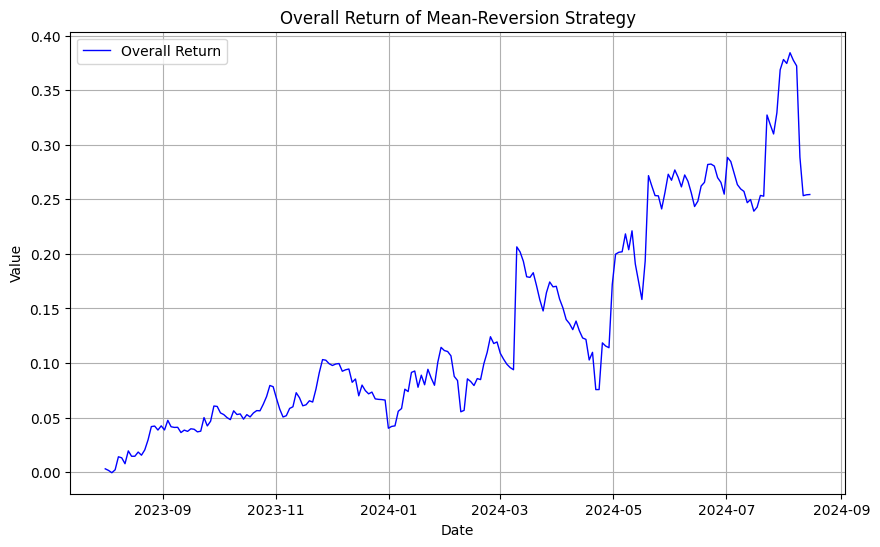

In [106]:
# calculating overall return of the strategy
strategy_df = deepcopy(return_df)
strategy_df = pd.DataFrame(strategy_df)
strategy_df["overall_ret"] = strategy_df.mean(axis=1)
strategy_df['overall_ret'].fillna(1)

start_date = "2023-08-01"
end_date = "2024-08-21"

# calculating the number of business days
date_range = pd.date_range(start=start_date, end=end_date, periods = len(strategy_df)) 
strategy_df.index = date_range

# Plotting overall return of the strategy
plt.figure(figsize=(10, 6))
plt.plot(strategy_df.index, strategy_df["overall_ret"].cumprod() - 1, label="Overall Return", color='blue', linewidth=1)
plt.title('Overall Return of Mean-Reversion Strategy')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()

From the plot, the strategy shows a gradual and consistent increase in returns during the early phase. It suggests that the mean-reversion strategy was initially effective in capturing small, profitable price reversions. The market condition is conducive to the strategy, enabling it to generate gains. While during the middle phases, from November 2023 to May 2024, the graph shows a great volatility in returns (from $0.05$ to $0.20$). This implies that the market conditions were less favorable for mean-reversion strategy. The trading strategy is unable to capture accurate trading signals under strong trends or reversals. Eventually, the strategy produces a huge increase in returns from May 2024 to August 2024, reaching a peak of about $0.38$. This phase is characterized by a strong upward movement with relatively smaller fluctuations compared to the previous period. The trading strategy is especially effective in this trading period. It may have capitalized on several profitable opportunities, leading to substantial gains. And low volatility implies that the market is stable during this period. 

The overall return plot for the mean-reversion strategy indicates a generally successful performance, with the strategy being able to generate positive returns of $0.20$ over the trading period. However, the observed volatility and the recent pullback highlight the need for adjustments of indicators. To improve the mean-reversion strategy's performance in unstable markets, further refinement of the indicators is necessary to better capture trading signals during periods of market instability.

And below is the plot of each stickers' return over the trading period.

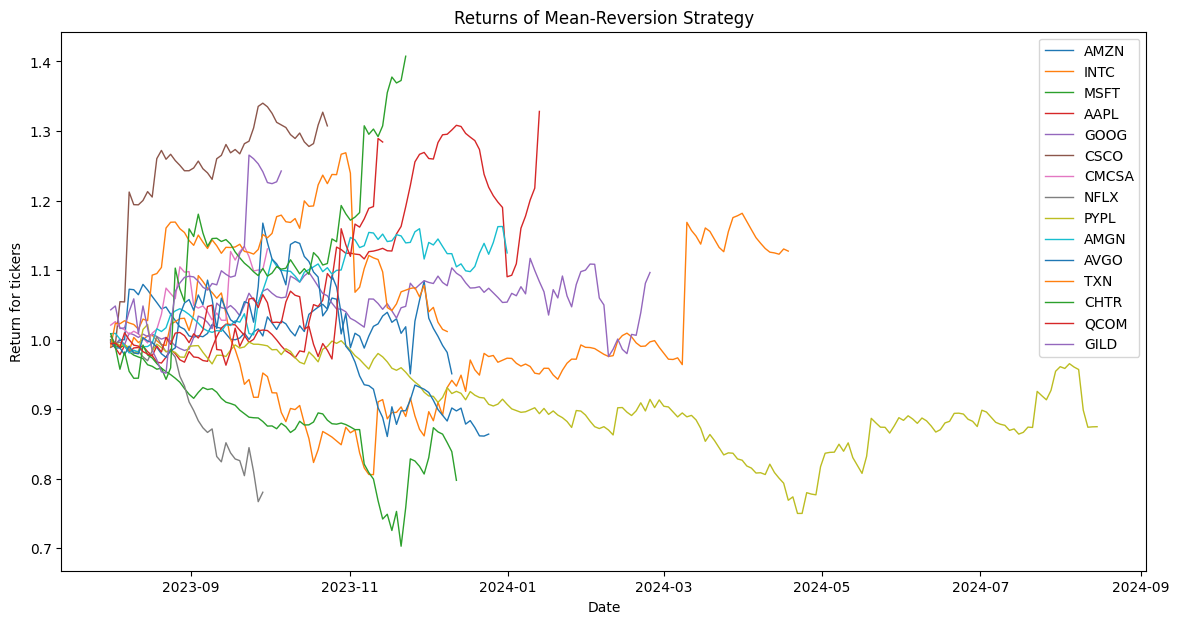

In [98]:
# plotting the returns for each ticker
plt.figure(figsize=(14, 7))
for ticker in return_df:
    plt.plot(strategy_df.index, strategy_df[ticker].cumprod(), label=ticker, linewidth=1)

plt.title('Returns of Mean-Reversion Strategy')
plt.xlabel('Date')
plt.ylabel('Return for tickers')
plt.legend()
plt.show()

##### Evaluation & KPIs #####
To further examine the performance of the trading strategies, I introduce some key performance indictors. KPIs provide a clear, quantitative measure of how well the strategy is performing. First, I compute the compounded annual growth rate (CAGR). The Compound Annual Growth Rate (CAGR) is basically the geometric mean annual growth rate of an investment over a specified period of time. CAGR smoothes out the effect of volatility. It can be calculated by,

$$
\text{CAGR} = \left( \frac{\text{Ending Value}}{\text{Beginning Value}} \right)^{\frac{1}{n}} - 1
$$

In this case, since we are getting the 15-Min historical bars, we have to devide the time by $252 * 26$ (there are 252 trading days a year, and 26 15-Min candles each trading day). Therefore, I have implemented the function `CAGR` to compute the compounded annual growth rate.

In [84]:
# calculate the Cumulative Annual Growth Rate
def CAGR(df_dict):
    df = df_dict.copy()
    df = df[df["return"] <= 3]
    df["cum_return"] = (1 + df["return"]).cumprod()
    n = len(df) / (252 * 26) #26 15-min candles each trading day
    cagr = (df["cum_return"].iloc[-1])**(1 / n) - 1
    return cagr

Hence, we may get the CAGR of each tickers. It can be observed that the majority of the stocks listed have positive CAGRs, which indicates that they have grown in value over the specified period. For example, stocks like Charter Communications (CHTR), Gilead Sciences (GILD), and Amgen (AMGN) all show strong growth rates, indicating that they were good investments under the current trading strategies. However, there are still some stocks with negative CAGR, like Microsoft (MSFT) and Amazon (AMZN). This is probably because the technology market is volatile and even having a poor market condition. The current trading strategy does not fully capture the trading signal, hence resulting losses. Overall, the CAGR results show that most of stocks have a moderate and strong growth pattern. This again proves the success of our mean-reversion strategy.

In [85]:
for ticker in tickers:
    print("CAGR of {} = {:.4f}".format(ticker, CAGR(ohlc_dict[ticker])))

CAGR of AMZN = 0.0356
CAGR of INTC = 0.2558
CAGR of MSFT = -0.0165
CAGR of AAPL = 0.1639
CAGR of GOOG = 0.1326
CAGR of CSCO = 0.1514
CAGR of CMCSA = 0.2548
CAGR of NFLX = -0.0293
CAGR of PYPL = 0.0717
CAGR of AMGN = 0.2980
CAGR of AVGO = 0.2909
CAGR of TXN = 0.2056
CAGR of CHTR = 0.6761
CAGR of QCOM = 0.2588
CAGR of GILD = 0.3108


Aside from CAGR, I then compute the Sharpe Ratio. The Sharpe Ratio is a measure of the risk-adjusted return of an investment or portfolio. It is calculated by subtracting the risk-free rate from the portfolio's return and then dividing the result by the standard deviation of the portfolio's return. Specifically, the Sharpe Ratio is calculated as follows:
$$
\text{Sharpe Ratio} = \frac{\text{Average Portfolio Return} - \text{Risk-Free Rate}}{\text{Standard Deviation of Portfolio Return}}
$$

Here, I first implement `volatility` to calculate the volatility. THen, I write the function `sharpe` to computer the sharpe ratio.

In [91]:
# calculate annual volatility
def volatility(df_dict):
    df = df_dict.copy()
    df = df[df["return"] <= 3]
    vol = df["return"].std() * np.sqrt(252 * 26)
    return vol

# calculate sharpe ratio
# rf rate is the risk free rate
def sharpe(df_dict, rf_rate):
    df = df_dict.copy()
    df = df[df["return"] <= 2]
    sharpe = (CAGR(df) - rf_rate) / volatility(df)
    return sharpe

In [92]:
for ticker in tickers:
    print("Sharpe Ratio of {} = {:.4f}".format(ticker, sharpe(ohlc_dict[ticker], 0.03)))

Sharpe Ratio of AMZN = 0.0493
Sharpe Ratio of INTC = 1.2194
Sharpe Ratio of MSFT = -0.4456
Sharpe Ratio of AAPL = 1.2264
Sharpe Ratio of GOOG = 0.8705
Sharpe Ratio of CSCO = 0.9139
Sharpe Ratio of CMCSA = 1.7142
Sharpe Ratio of NFLX = -0.5196
Sharpe Ratio of PYPL = 0.2956
Sharpe Ratio of AMGN = 1.6862
Sharpe Ratio of AVGO = 1.6033
Sharpe Ratio of TXN = 1.1587
Sharpe Ratio of CHTR = 3.1188
Sharpe Ratio of QCOM = 1.7287
Sharpe Ratio of GILD = 1.7561


Sharpe Ratio mainly evaluates the efficiency of the mean-reversion strategy by comparing the returns earned relative to the risk taken. In this case, a higher Sharpe Ratio indicates that the investment is providing a better return for risk taken, while a lower or negative Sharpe Ratio indicates poor risk-adjusted performance. For example, the Apple AAPL, Qualcomm QCOM, Gilead Sciences (GILD) all have a high sharpe ratio, greater than $1.2$. This further suggest that these stocks have offered strong, and stable returns with low risks. On the other hand, stocks like Google (GOOG), Cisco (CSCO), and Paypal (PYPL) have Sharpe Ratios just below $1$, indicating that their returns are roughly commensurate with the level of risk taken. Most notably, Microsoft (MSFT) and Netflix (NFLX) are particularly concerning due to their negative Sharpe Ratios. It shows that our trading strategy does not yield a positive return for these stocks, and the returns may not have been worth the risk. For the negative and lower sharpe-ratio stocks, it is better to hold a risk-free asset.

Last but not least, I have introduced Max drawdown as one of the KPIs. Maximum Drawdown is the maximum observed loss from a peak to a trough of a portfolio. It measures the largest drop from the highest point to lowest point. It can help us to assess the downside risk of investing stocks. Specifically, max drawdown is calculated as,
$$
\text{Max DD} = \frac{\text{Peak Value} - \text{Trough Value}}{\text{Peak Value}}
$$

Using the `max_drawdown` function, we are able to compute th max drawdown during the trading period.

In [94]:
# calculate maximum drawdown
def max_drawdown(df_dict):
    df = df_dict.copy()
    df["cum_return"] = (1 + df["return"]).cumprod() # cumulative return
    df["cum_roll_max"] = df["cum_return"].cummax() # cumulative maximum
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"] # drawdown
    df["drawdown_pct"] = df["drawdown"] / df["cum_roll_max"] # drawdown percentage
    max_drawdown = df["drawdown_pct"].max()
    return max_drawdown

In [95]:
for ticker in tickers:
    print("Max drawdown of {} = {:.4f}".format(ticker, max_drawdown(ohlc_dict[ticker])))

Max drawdown of AMZN = 0.0832
Max drawdown of INTC = 0.0630
Max drawdown of MSFT = 0.1752
Max drawdown of AAPL = 0.1116
Max drawdown of GOOG = 0.0898
Max drawdown of CSCO = 0.0601
Max drawdown of CMCSA = 0.0561
Max drawdown of NFLX = 0.0686
Max drawdown of PYPL = 0.1386
Max drawdown of AMGN = 0.0710
Max drawdown of AVGO = 0.0817
Max drawdown of TXN = 0.1431
Max drawdown of CHTR = 0.0679
Max drawdown of QCOM = 0.1121
Max drawdown of GILD = 0.0802


For stocks like CMCSA (max_drawdown = $0.0561$), CSCO (max_drawdown = $0.0601$), and CHTR (max_drawdown = $0.0679$), they experience a relatively low drawdowns, suggesting that our strategy was able to manage risk effectively, minimizing losses. While, for MSFT (max_drawdown = $0.1752$) and PYPL (max_drawdown = $0.1386$), they are of great risks and experience great decline during the trading period. But generally, our mean-reversion strategy is able to avoid huge losses and generate profits.

To further evaluate the strategies' performance, I compute key trading metrics, including win rate, mean return per trade, mean return per winning trade, and maximum consecutive loss. The win rate is calculated as the percentage of trades that are profitable. That is,
$$
\text{Win Rate} = \left( \frac{\text{Winning Trades}}{\text{Winning Trades} + \text{Losing Trades}} \right) \times 100
$$

In [108]:
# win rate of intraday trading strategy
def winRate(DF):
    df = DF["return"]
    pos = df[df > 1] # winning trades
    neg = df[df < 1] # losing trades
    return (len(pos) / len(pos+neg))*100

The mean return per trade is the average return of all trades. This metric provides a general insights of how much gains or loss can be expected from each trade on average. It helps assess the overall efficiency of the trading strategy.
$$
\text{Mean Return per Trade} = \frac{\sum (\text{Return}_i - 1)}{\text{Number of Trades}} 
$$
The mean return per winning trade is the average return of all profitable trades. 
$$
\text{Mean Return per Winning Trade} = \frac{\sum (\text{Return}_i - 1)}{\text{Number of Winning Trades}}
$$
And similarly, the mean return per losing trade is the average return of all unprofitable trades. They are each calculated as,
$$
\text{Mean Return per Losing Trade} = \frac{\sum (\text{Return}_i - 1)}{\text{Number of Losing Trades}}
$$
Using the function `meanretpertrade`, `meanretwintrade` and `meanretlostrade`, we are able to compute each stocks' mean return.

In [ ]:
# mean return per trade
def meanretpertrade(DF):
    df = DF["return"]
    df_temp = (df-1).dropna()
    return df_temp[df_temp!=0].mean()

# mean return per winning trade
def meanretwintrade(DF):
    df = DF["return"]
    df_temp = (df-1).dropna()
    return df_temp[df_temp>0].mean()

# mean return per losing trade
def meanretlostrade(DF):
    df = DF["return"]
    df_temp = (df-1).dropna()
    return df_temp[df_temp<0].mean()

In addition to metrics like win rate, mean return per trade, and others, the Max Consecutive Loss is an important metric that provides insight into the risk of a trading strategy. Specifically, Max Consecutive Loss refers to the largest sequence of consecutive losing trades that a strategy experiences during the trading period. It measures the number of losses that can occur in a row before the trading strategy begins to recover.
$$
\text{Max Consecutive Losses} = \max(\text{Consecutive Losses Sequence})
$$

In [111]:
# maximum consecutive wins
def maxconsectvloss(DF):
    df = DF["return"]
    df_temp = df.dropna(axis=0)
    df_temp2 = np.where(df_temp < 1,1,0)
    count_consecutive = []
    seek = 0
    for i in range(len(df_temp2)):
        if df_temp2[i] == 0:
            if seek > 0:
                count_consecutive.append(seek)
            seek = 0
        else:
            seek+=1
    if len(count_consecutive) > 0:
        return max(count_consecutive)
    else:
        return 0

Then, we compute the value of win rate, mean return per trade, max consecutive losses.

In [112]:
#calculating individual stock's KPIs
win_rate = {}
mean_ret_pt = {}
mean_ret_pwt = {}
mean_ret_plt = {}
max_cons_loss = {}
for ticker in tickers:
    win_rate[ticker] =  winRate(pd.DataFrame(return_df[ticker],columns=["return"]))      
    mean_ret_pt[ticker] =  meanretpertrade(pd.DataFrame(return_df[ticker],columns=["return"]))
    mean_ret_pwt[ticker] =  meanretwintrade(pd.DataFrame(return_df[ticker],columns=["return"]))
    mean_ret_plt[ticker] =  meanretlostrade(pd.DataFrame(return_df[ticker],columns=["return"]))
    max_cons_loss[ticker] =  maxconsectvloss(pd.DataFrame(return_df[ticker],columns=["return"]))

KPI_df = pd.DataFrame([win_rate,mean_ret_pt,mean_ret_pwt,mean_ret_plt,max_cons_loss],
                      index=["Win Rate","Mean Return Per Trade","Mean Return Per Winning Trade", "Mean Return Per Losing Trade", "Max Consecutive Loss"])      
KPI_df.T

,Win Rate,Mean Return Per Trade,Mean Return Per Winning Trade,Mean Return Per Losing Trade,Max Consecutive Loss
AMZN,42.666667,-0.000451,0.015593,-0.012391,6.0
INTC,39.189189,0.001131,0.019528,-0.010725,8.0
MSFT,26.315789,-0.002734,0.018617,-0.010360,12.0
AAPL,46.808511,0.003187,0.015254,-0.007431,11.0
GOOG,38.983051,0.000910,0.015295,-0.008280,12.0
CSCO,50.000000,0.005900,0.018694,-0.006894,7.0
CMCSA,48.571429,0.003754,0.018066,-0.009764,3.0
NFLX,29.411765,-0.007058,0.015197,-0.016330,8.0
PYPL,37.674419,-0.000530,0.011340,-0.007705,8.0
AMGN,51.724138,0.001426,0.009933,-0.007690,7.0


From the table, stocks (AMGN, GILD, CSCO) with a win rate greater than $50$ implies that the trading strategy results in a quite successfull and profitable trade. Meanwhile, a positive mean return per trade indicates that, on average, each trade contributes positively to the overall strategy return. Our mean return per trade for stocks is mostly positive, further indicating the success of the strategy. And the mean return per winning trade is quite high, implying that our strategy captures great profits on winning trades. More importantly, when we look at the max consecutive loss, a high max consecutive loss over $10$ (AAPL, GOOG, AMGN) suggests that the strategy can suffer several losses in a row. This could be stressful for real-time trading and require a larger capital reserve to withstand the drawdown.

##### Overall Assessment #####
Generally, the mean-reversion strategy is quite effective, with a overall return of $0.0886$ over one year. The strategy demonstrates effectiveness with certain stocks, such as CHTR, CSCO, GILD, and AAPL, where the mean returns per trade and per winning trade are positive, and the win rates are reasonable. These stocks also exhibit well-controlled losses, as reflected in their lower mean returns per losing trade and manageable max consecutive losses, indicating that the mean-reversion strategy is able to capitalize on price reversals while limiting downside risks. 

However, the mean-reversion strategy struggles with stocks like MSFT, NFLX, and PYPL, where the mean returns per trade are negative, and the win rates are low. These stocks also experienced significant max consecutive losses, indicating a lack of robustness in volatile or trending market conditions. Our strategy faces great losses under volatile and poor market conditions. Therefore, the trading strategy might benefit from refining the indicators (ADX and RSI) used to generate signals. We can see that RSI is a powerful indicators when trading. Potentially, implementing a stricter stop-loss rule may help reducing the max consecutive losses. This mean-reversion strategy could further be tested through real-time trading.

#### Trend-Following Strategy ####
The trend-following strategy is a trading approach that aims to capitalize on the momentum of market trends. Unlike mean-reversion strategies, which seek to take profit from price corrections, trend-following strategies profit by aligning with the market's prevailing direction, whether it is upward (bullish) or downward (bearish) trend. By using technical indicators such as moving averages, the Average Directional Index (ADX), and the Moving Average Convergence Divergence (MACD), trend-following strategies can effectively generate buy and sell signals, helping us to keep track of the market's momentum. 

##### Technical Indicators #####
Aside from Relative Strength Index RSI and Average Directional Index, we also utilize MACD and Stochastic oscillator as indicators in our trend-following strategy.

> Moving Average Convergence Divergence (MACD)

The Moving Average Convergence Divergence is a technical indicator used in trend-following strategies to identify the momentum and direction of an stock’s price. And MACD is composed of three parts,
- MACD Line: the difference between two Exponential Moving Average Line (one slow EMA and one fast EMA line)
- Signal Line: EMA of the MACD line
- Histogram: the difference between the MACD line and the Signal line

Specifically, each part is calculated by,
$$
\text{EMA}_{\text{fast}} = \text{EMA}_{12} = \text{Price}_{t} \times \left( \frac{2}{span +1} \right) + \text{EMA}_{t-1} \times \left( 1 - \frac{2}{span +1} \right)
$$
where,
- $\text{Price}_{t}$ it stock price at time $t$
- $\text{EMA}_{t-1}$ it the EMA at time $t-1$
- span is the time span for fast moving average, take span = $12$ here

Similarly, the slow moving average $\text{EMA}_{\text{Long}}$ is calculated over a longer time frame, 26 days. The $\text{EMA}_{\text{Long}}$ line reacts more slowly to price changes.
$$
\text{EMA}_{\text{slow}} = \text{EMA}_{26} = \text{Price}_{t} \times \left( \frac{2}{26 +1} \right) + \text{EMA}_{t-1} \times \left( 1 - \frac{2}{26 +1} \right)
$$

Thus, the MACD Line can be obtained by,
$$
\text{MACD Line} = \text{EMA}_{fast} - \text{EMA}_{slow}
$$
where,
- $\text{EMA}_{fast}$ is the fast moving average, usually $\text{EMA}_{12}$
- $\text{EMA}_{slow}$ is the slow moving average, in this case, $\text{EMA}_{26}$

And the signal line is just the $9$-day EMA of the MACD line, namely, 
$$
\text{Signal Line} = \text{EMA}_{9} \text{ of MACD} = \text{MACD}_{t} \times \left( \frac{2}{9 +1} \right) + \text{EMA}_{t-1} \times \left( 1 - \frac{2}{9 +1} \right)
$$
Then, I implement the function `MACD` to compute the MACD Line.

In [128]:
# function to calculate Moving Average Convergence / Divergence (MACD)
# typical values a(fast moving average) = 12; 
# b(slow moving average) = 26; 
# c(signal line ma window) = 9
def MACD(df_dict, a=12 , b=26, c=9):
    for df in df_dict:
        df_dict[df]["ma_fast"] = df_dict[df]["close"].ewm(alpha = 1/a, min_periods=a).mean()
        df_dict[df]["ma_slow"] = df_dict[df]["close"].ewm(alpha = 1/b, min_periods=b).mean()
        df_dict[df]["macd"] = df_dict[df]["ma_fast"] - df_dict[df]["ma_slow"]
        df_dict[df]["signal"] = df_dict[df]["macd"].ewm(alpha = 1/c, min_periods=c).mean()
        df_dict[df].drop(["ma_fast","ma_slow"], axis=1, inplace=True)

> Stochastic Oscillator

Aside from MACD, we incorporate Stochastic as one indicator of our trend-following strategy. The Stochastic Oscillator is a momentum indicator that compares a particular closing price of a security to a range of its prices over a certain period of time. The stochastic mainly consists of two lines, namely,
- %K line, current closing price relative to the high-low range over a number of periods.
- %D line, the signal line. 3-day moving average of %K line.

Specifically, the $\%K$ line is calculated as,

$$
\%K = \frac{\text{Current Close} - \text{Lowest Low}}{\text{Highest High} - \text{Lowest Low}} \times 100
$$

where,
- $\text{Current Close}$ is the current closing price.
- $\text{Lowest Low}$ is the lowest price over the look-back period.
- $\text{Highest High}$ is the highest price over the look-back period.

Therefore, the $\% D$ line is the 3-day simple moving average of the $\% K$ line.

$$
\%D = \text{SMA}_{3}(\%K)
$$

In [114]:
# function to calculate Stochastic Oscillator
# lookback = lookback period
# k and d = moving average window for %K and %D
def stochastic(df_dict, lookback=14, k=3, d=3):
    for df in df_dict:
        df_dict[df]["HH"] = df_dict[df]["high"].rolling(lookback).max() # highest high over lookback period
        df_dict[df]["LL"] = df_dict[df]["low"].rolling(lookback).min() # lowest low over lookback period
        df_dict[df]["%K"] = (100 * (df_dict[df]["close"] - df_dict[df]["LL"]) / (df_dict[df]["HH"]-df_dict[df]["LL"])).rolling(k).mean()
        df_dict[df]["%D"] = df_dict[df]["%K"].rolling(d).mean()
        df_dict[df].drop(["HH","LL"], axis=1, inplace=True)

##### Core Strategies #####
For the trend-following strategy, we consider the crossover of stochastic line (%K line crosses above the %D line) and $ADX$ over $25$ as oversold (uptrend); when $RSI$ is greater than $80$, %K greater than 80, and the %K line crosses below the %D line, it is considered as overbought (downtrend). A high ADX value (typically above 25 or 30) indicates a strong trend, whether it’s bullish or bearish. In markets with low ADX values, price movements may lack the momentum needed to sustain a breakout. Therefore, we set the ADX threshold as $25$ to trade in a relatively strong trend. This filter helps avoid entering trades in weak, choppy markets where price movements might lack momentum.

$$
Signal = \begin{cases} 
1 & \text{if } ADX > 25 \text{ and } \%K < 20 \text { and } \%K > \%D \text{ and } \text{MACD} > \text{Signal}\\
-1 & \text{if } ADX > 25 \text{ and } \%K > 80 \text { and } \%K < \%D \text{ and } \text{MACD} < \text{Signal}\\
0 & \text{otherwise}
\end{cases}
$$

Additionally, we apply the MACD to better the decision-making. Specifically, a bullish signal occurs when the MACD line crosses above the Signal line. It indicates that the momentum of stock is going upwards. On the other hand, a bearish signal occurs when the MACD line crosses below the Signal line. Here, we also use the zero line crossover and crossover of 30-day EMA as the signal indicators. When combined with other indicators like the Average Directional Index (ADX) and Moving Average Convergence Divergence (MACD), the Stochastic Oscillator can help reduce the likelihood of acting on false signals. The ADX ensures that trades are only taken in strong trends, while the Stochastic and MACD help confirm the timing.

Just like mean-reversion strategy, when placing a buying or selling order, we also place a stop-loss order below the most recent swing low (for long positions) or above the most recent swing high (for short positions) to protect against unexpected market moves. The trailing loss percent set as $1.5 \%$. 

In [177]:
# tickers
tickers = ['AMZN','INTC','MSFT','AAPL','GOOG','CSCO','CMCSA'
           ,'NFLX','PYPL','AMGN','AVGO','TXN','CHTR','QCOM','GILD']
#extract and store historical data in dataframe
historicalData = hist_data(tickers, start_date ="2023-08-01", timeframe="Minute") 

############################# BACKTESTING  ##################################
ohlc_dict = deepcopy(historicalData)
stoch_signal = {}
adx_signal = {}
tickers_signal = {}
tickers_ret = {}
trade_count = {}
long_data = {}
short_data = {}
hwm = {}
# calculating indicators
EMA(ohlc_dict,30)
MACD(ohlc_dict)
stochastic(ohlc_dict)
ADX(ohlc_dict)
RSI(ohlc_dict)
# initializing the signals
for ticker in tickers:
    stoch_signal[ticker] = ""
    adx_signal[ticker] = ""
    trade_count[ticker] = 0
    tickers_signal[ticker] = ""
    hwm[ticker] = 0
    tickers_ret[ticker] = [0]
    long_data[ticker] = {}
    short_data[ticker] = {}

for ticker in tickers:
    for i in range(1,len(ohlc_dict[ticker])-1):
        if ohlc_dict[ticker]["%K"].iloc[i] < 25 and \
        ohlc_dict[ticker]["%K"].iloc[i] > ohlc_dict[ticker]["%D"].iloc[i] and \
        ohlc_dict[ticker]["ADX"].iloc[i] > 25: # oversold
            stoch_signal[ticker] = "oversold"
        elif ohlc_dict[ticker]["%K"].iloc[i] > 80 and \
            ohlc_dict[ticker]["%K"].iloc[i] < ohlc_dict[ticker]["%D"].iloc[i] and \
            ohlc_dict[ticker]["ADX"].iloc[i] > 25: # overbought
            stoch_signal[ticker] = "overbought"
        
        if tickers_signal[ticker] == "":
            tickers_ret[ticker].append(0)
            if ohlc_dict[ticker]["macd"].iloc[i] > ohlc_dict[ticker]["signal"].iloc[i] and \
            ohlc_dict[ticker]["macd"].iloc[i] > 0 and \
            ohlc_dict[ticker]["close"].iloc[i] > ohlc_dict[ticker]["ema"].iloc[i] and \
               stoch_signal[ticker]=="oversold": # buying signal
                   tickers_signal[ticker] = "Buy"
                   trade_count[ticker] += 1
                   long_data[ticker][trade_count[ticker]] = [ohlc_dict[ticker]["open"].iloc[i+1]]
                   hwm[ticker] = ohlc_dict[ticker]["open"].iloc[i+1]
            elif ohlc_dict[ticker]["macd"].iloc[i] < ohlc_dict[ticker]["signal"].iloc[i] and \
            ohlc_dict[ticker]["macd"].iloc[i] < 0 and \
            ohlc_dict[ticker]["close"].iloc[i] > ohlc_dict[ticker]["ema"].iloc[i] and \
               stoch_signal[ticker]=="overbought": # selling signal
                   tickers_signal[ticker] = "Sell"
                   trade_count[ticker] += 1
                   short_data[ticker][trade_count[ticker]] = [ohlc_dict[ticker]["open"].iloc[i+1]]
                   hwm[ticker] = ohlc_dict[ticker]["open"].iloc[i+1]
                     
        elif tickers_signal[ticker] == "Buy":
            if ohlc_dict[ticker]["low"].iloc[i] < 0.99 * hwm[ticker]:
                tickers_signal[ticker] = ""
                long_data[ticker][trade_count[ticker]].append(0.99 * hwm[ticker])
                trade_count[ticker] += 1
                tickers_ret[ticker].append((0.99 * hwm[ticker] / ohlc_dict[ticker]["close"].iloc[i-1])-1)
            else:
                hwm[ticker] = max(hwm[ticker],ohlc_dict[ticker]["high"].iloc[i])
                tickers_ret[ticker].append((ohlc_dict[ticker]["close"].iloc[i] / ohlc_dict[ticker]["close"].iloc[i-1])-1)

        elif tickers_signal[ticker] == "Sell":
            if ohlc_dict[ticker]["high"].iloc[i] > 1.010 * hwm[ticker]:
                tickers_signal[ticker] = ""
                short_data[ticker][trade_count[ticker]].append(1.010 * hwm[ticker])
                trade_count[ticker] += 1
                tickers_ret[ticker].append((ohlc_dict[ticker]["close"].iloc[i-1] / 1.010 *hwm[ticker])-1)
            else:
                hwm[ticker] = ohlc_dict[ticker]["low"].iloc[i]
                tickers_ret[ticker].append((ohlc_dict[ticker]["close"].iloc[i-1] / ohlc_dict[ticker]["close"].iloc[i])-1)
    
    if trade_count[ticker] % 2 != 0: # merge the trade dataframe together
        for trade in long_data[ticker]:
            if len(long_data[ticker][trade]) == 1:
                long_data[ticker][trade].append(ohlc_dict[ticker]["close"].iloc[i])
        for trade in short_data[ticker]:
            if len(short_data[ticker][trade]) == 1:
                short_data[ticker][trade].append(ohlc_dict[ticker]["close"].iloc[i])
        
    tickers_ret[ticker].append(0)
    ohlc_dict[ticker]["return"] = np.array(tickers_ret[ticker])  

##### Backtesting #####
Below is the backtesting of the trend-following strategy. We first calculate the return for each trade as the ratio of entry price to exit price. If there are no long trades, use the short trade returns; if there are no short trades, use the long trade returns; and if both exist, concatenate the returns and sort by index. Lastly, after calculating the cumulative product of returns, we derive the overall return of our portfolios.

In [178]:
################################# Backtesting Overall Return ##################################
long_df = {} # long trade dataframe
short_df = {} # short trade dataframe
return_df = {} # return dataframe
overall_return = 0
overall_return_list = {}
for ticker in tickers:
    try:
        long_df[ticker] = pd.DataFrame(long_data[ticker]).T
        long_df[ticker].columns = ["long_entry_pr","long_exit_pr"]
        long_df[ticker]["return"] = long_df[ticker]["long_exit_pr"] / long_df[ticker]["long_entry_pr"]
    except:
        print("no long trades for ", ticker)
    try:
        short_df[ticker] = pd.DataFrame(short_data[ticker]).T
        short_df[ticker].columns = ["short_entry_pr","short_exit_pr"]
        short_df[ticker]["return"] = short_df[ticker]["short_entry_pr"] / short_df[ticker]["short_exit_pr"]
    except:
        print("no short trades for ", ticker)

    if len(long_df[ticker]) == 0:
        return_df[ticker] = short_df[ticker]["return"]
    elif len(short_df[ticker]) == 0:
        return_df[ticker] = long_df[ticker]["return"]
    else:
        return_df[ticker] = pd.concat([long_df[ticker]["return"],short_df[ticker]["return"]]).sort_index()   
    print("Total return of {} = {:.4f}".format(ticker, return_df[ticker].cumprod().iloc[-1]- 1))
    overall_return += (1 / len(tickers)) * (return_df[ticker].cumprod().iloc[-1] - 1)

print("Overall Return of Trend Following Strategy = {:.4f}".format(overall_return))

Total return of AMZN = -0.0436
Total return of INTC = 0.1147
Total return of MSFT = -0.1903
Total return of AAPL = 0.1472
Total return of GOOG = 0.1656
Total return of CSCO = 0.0446
Total return of CMCSA = -0.0954
Total return of NFLX = 0.1303
Total return of PYPL = 0.1420
Total return of AMGN = 0.1634
Total return of AVGO = 0.4669
Total return of TXN = 0.0364
Total return of CHTR = 0.0618
Total return of QCOM = 0.0241
Total return of GILD = 0.2107
Overall Return of Trend Following Strategy = 0.0919


The overall return of the trend following strategy is **0.0919**. There are some underperformers, like CMC and MSFT, with a cumulative return of $-0.0954$ and $-0.1903$ respectively. Under some circumstances, even though the ADX and stochastic indicators suggests that it is overbought / oversold, the stock price, in reality, is just doing the opposite. Trend-following strategies normally perform poorly in volatile or sideways markets where there is no clear trend. It is hard to capture a clear trend under sharpe price movement, hence the production of some false signals. With false signals, the strategy will have entering or exiting trades prematurely, leading to losses. Also, both MACD and ADX are lagging indicators, meaning that they respond to price changes after they occur. Therefore, in a rapid-changing market, these indicators can easily result in delayed entry or exit.

Despite some underperforming stocks, for majority of stocks, the trend-following strategy still produces a positive return. The strategy’s conservative approach to entering trades in only strong trends, combined with balanced risk management, has helped to ensure positive returns across a majority of the stocks analyzed. The strategy yielded a positive return of $0.0919$. And the trend-following strategy performs well with stocks that exhibited strong, sustained trends, such as AVGO ($0.4669$), GILD ($0.2107$), and AMGN ($0.1634$). This indicates that the combination of Stochastic, ADX, and MACD is effective in capturing significant price movements. By focusing on strong trends as identified by the ADX, the strategy was able to enter trades early in the trend and ride them for significant profits, particularly in stocks that had favorable market conditions/ Meanwhile, it is worth-noticing that the trend-following strategy is particularly effective in sectors where trends were more pronounced. For example, the trend-following strategy is more adapted to the healthcare and technology sectors, where the trends is strong. Moreover, one strength of our strategy is that it is capable of handling different market environments (no matter it is uptrending or downtrending). 



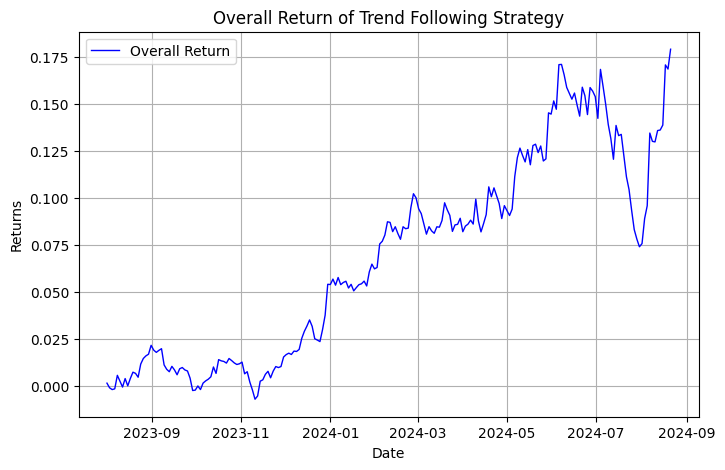

In [162]:
# calculating overall return of the strategy
strategy_df = deepcopy(return_df)
strategy_df = pd.DataFrame(strategy_df)
strategy_df["overall_ret"] = strategy_df.mean(axis=1)
strategy_df['overall_ret'].fillna(1)

start_date = "2023-08-01"
end_date = "2024-08-21"
# calculating the number of business days
date_range = pd.date_range(start=start_date, end=end_date, periods = len(strategy_df)) 
strategy_df.index = date_range

# Plotting overall return of the strategy
plt.figure(figsize=(8, 5))
plt.plot(strategy_df.index, strategy_df["overall_ret"].cumprod() - 1, label="Overall Return", color='blue', linewidth=1)
plt.title('Overall Return of Trend Following Strategy')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()

For the trend-following strategy, its returns is greatly affected by the underlying stock selection and the market conditions. The strategy might have been applied to stocks with a higher likelihood of trending, either due to strong fundamentals, positive news, or favorable sector dynamics. Therefore, further refinement of the trading strategy could be made by selecting trending stocks. And integrating sentiment analysis from news and social media could also provide a layer of market sentiment, which may improve the timing and selection of trades. Last but not least, we could implement the dynamic stop-losses and take-profits order based on the Average True Range (ATR) or other volatility measures to better adapt to changing market environments.

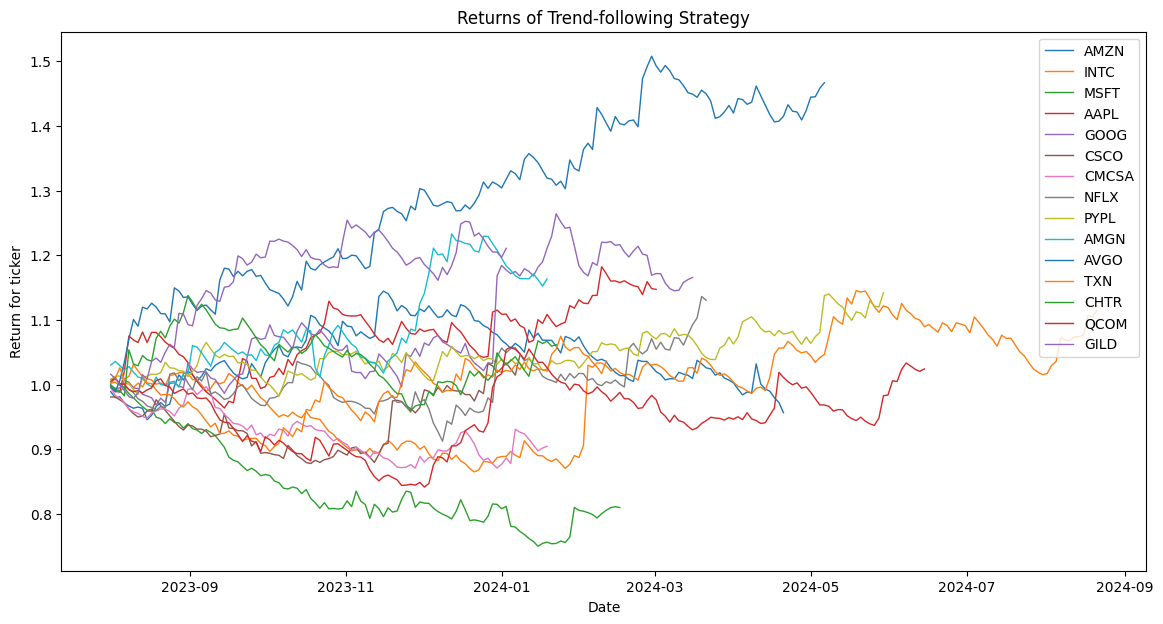

In [171]:
# plotting the returns for each ticker
plt.figure(figsize=(14, 7))
for ticker in return_df:
    plt.plot(strategy_df.index, strategy_df[ticker].cumprod(), label=ticker, linewidth=1)
plt.title('Returns of Trend-following Strategy')
plt.xlabel('Date')
plt.ylabel('Return for ticker')
plt.legend()
plt.show()

##### Evaluation & KPIs #####
To better evaluate the performance of trend-following strategy, I introduce the performance metrics.
First, we compute the Compounded Annual Growth Rate (CAGR) of each ticker.

In [164]:
for ticker in tickers:
    print("CAGR of {} = {:.4f}".format(ticker, CAGR(ohlc_dict[ticker])))

CAGR of AMZN = 0.0516
CAGR of INTC = 0.0768
CAGR of MSFT = -0.0286
CAGR of AAPL = 0.1368
CAGR of GOOG = 0.1531
CAGR of CSCO = 0.1039
CAGR of CMCSA = 0.0476
CAGR of NFLX = 0.2054
CAGR of PYPL = 0.1062
CAGR of AMGN = 0.0934
CAGR of AVGO = 0.3683
CAGR of TXN = 0.1161
CAGR of CHTR = 0.1319
CAGR of QCOM = 0.0987
CAGR of GILD = 0.1904


The strategy achieved positive CAGR for the majority of stocks, which indicates that, on average, the strategy was able to generate returns over the time period analyzed. The negative CAGR for MSFT ($-0.0286$) indicates that the strategy was not effective for this stock, resulting in a compounded loss over the period. This could be due to market conditions that are not favorable for our trend-following trading strategy. Still, we have some top performers, like AVGO ($0.3683$) and NFLX ($0.2054$). Compared to mean-reversion strategy, these stocks seem to perform better when applying trend-following strategy.

The performance differences could be tied to sector-specific trends. For example, AVGO (a technology stock) may have benefited from strong sector-wide bullish trends, while MSFT might have faced more sector-specific challenges or been more impacted by market volatility.

In [165]:
for ticker in tickers:
    print("Sharpe Ratio of {} = {:.4f}".format(ticker, sharpe(ohlc_dict[ticker], 0.03)))

Sharpe Ratio of AMZN = 0.2382
Sharpe Ratio of INTC = 0.4258
Sharpe Ratio of MSFT = -0.6763
Sharpe Ratio of AAPL = 1.1208
Sharpe Ratio of GOOG = 1.0481
Sharpe Ratio of CSCO = 0.6154
Sharpe Ratio of CMCSA = 0.1648
Sharpe Ratio of NFLX = 1.6334
Sharpe Ratio of PYPL = 0.7302
Sharpe Ratio of AMGN = 0.5360
Sharpe Ratio of AVGO = 2.8056
Sharpe Ratio of TXN = 0.7271
Sharpe Ratio of CHTR = 0.9105
Sharpe Ratio of QCOM = 0.5766
Sharpe Ratio of GILD = 1.5094


From the sharpe ratio results, we may observe that the trend-following strategy performs extremely well on stocks AVGO, NFLX, GILD, AAPL, and GOOG. The strategy provides a good balance of risk and return for these stocks. However, for stocks like MSFT ($-0.6763$), CMCSA, etc, the strategy provides minimal or poor risk-adjusted returns for these stocks. This further suggests that these stocks might experience more volatility or weaker trends, making it difficult for trend-following strategy to perform well.

In [166]:
for ticker in tickers:
    print("Max drawdown of {} = {:.4f}".format(ticker, max_drawdown(ohlc_dict[ticker])))

Max drawdown of AMZN = 0.0704
Max drawdown of INTC = 0.1367
Max drawdown of MSFT = 0.0741
Max drawdown of AAPL = 0.0896
Max drawdown of GOOG = 0.0555
Max drawdown of CSCO = 0.0736
Max drawdown of CMCSA = 0.0505
Max drawdown of NFLX = 0.0495
Max drawdown of PYPL = 0.0545
Max drawdown of AMGN = 0.0947
Max drawdown of AVGO = 0.0596
Max drawdown of TXN = 0.0960
Max drawdown of CHTR = 0.1141
Max drawdown of QCOM = 0.0877
Max drawdown of GILD = 0.0703


The Max Drawdown analysis suggests that our trend-following strategy was generally effective in managing risk, with most stocks experiencing moderate drawdowns. The strategy was particularly successful with stocks like NFLX ($0.0495$), CMCSA ($0.0545$), and GOOG ($0.0555$), which had very low drawdowns. These stocks may have experienced consistent trends with few reversal, indicating strong risk management. However, for technology and communications stocks like CHTR and INTC, we are potentially facing larger risks. This again stresses the importance of trailing loss orders.

In [167]:
#calculating individual stock's KPIs
win_rate = {}
mean_ret_pt = {}
mean_ret_pwt = {}
mean_ret_plt = {}
max_cons_loss = {}
for ticker in tickers:
    win_rate[ticker] =  winRate(pd.DataFrame(return_df[ticker],columns=["return"]))      
    mean_ret_pt[ticker] =  meanretpertrade(pd.DataFrame(return_df[ticker],columns=["return"]))
    mean_ret_pwt[ticker] =  meanretwintrade(pd.DataFrame(return_df[ticker],columns=["return"]))
    mean_ret_plt[ticker] =  meanretlostrade(pd.DataFrame(return_df[ticker],columns=["return"]))
    max_cons_loss[ticker] =  maxconsectvloss(pd.DataFrame(return_df[ticker],columns=["return"]))

KPI_df = pd.DataFrame([win_rate,mean_ret_pt,mean_ret_pwt,mean_ret_plt,max_cons_loss],
                      index=["Win Rate","Mean Return Per Trade","Mean Return Per Winning Trade", "Mean Return Per Losing Trade", "Max Consecutive Loss"])      
KPI_df.T

,Win Rate,Mean Return Per Trade,Mean Return Per Winning Trade,Mean Return Per Losing Trade,Max Consecutive Loss
AMZN,32.885906,-0.000226,0.012823,-0.006620,11.0
INTC,38.073394,0.000584,0.011232,-0.005962,10.0
MSFT,32.743363,-0.001795,0.010451,-0.007757,9.0
AAPL,38.842975,0.001232,0.013925,-0.006829,16.0
GOOG,41.085271,0.001328,0.013904,-0.007442,7.0
CSCO,38.461538,0.000570,0.012129,-0.006655,6.0
CMCSA,35.051546,-0.000980,0.009422,-0.006593,9.0
NFLX,40.151515,0.001031,0.013376,-0.007250,10.0
PYPL,46.198830,0.000828,0.008987,-0.006178,8.0
AMGN,38.144330,0.001661,0.015714,-0.007005,10.0


Here is a detailed analysis of the key performance metrics. The win rates for most stocks hover around $32\%$ to $46\%$. Compared to mean-reversion strategy, trend-following strategy has a relatively low win rate, meaning it make profits for less than half of the trading time. However, the mean return per trade furthe compensate the low win rates. The strategy yields a high mean return per trade for stocks AVGO and GILD. The higher mean returns per winning trade for stocks like AMGN ($0.0157$) and AAPL ($0.0139$) indicate that when the strategy worked, it captured significant gains, but the relatively higher mean returns per losing trade for MSFT and AMZN highlight potential weaknesses in risk management.
And our strategy struggled with stocks like MSFT and CMCSA, where the mean returns per trade are negative, and the max consecutive losses are relatively high. It implies that our strategy fail to identify profitable trends or manage volatility effectively in these cases. Most importantly, AAPL and CHTR has a max consecutive loss of $16$ and $12$. This reminds us to conduct risk management when our strategy produce false signals. 

##### Overall Assessment #####
Generally, our trend-following strategy exhibits promise in most of stocks, demonstrating effectiveness across the broader portfolio. The strategy proves to be particularly profitable in scenarios where clear and strong trends are observed, capitalizing on these sustained movements to generate significant returns. The Moving Average Convergence Divergence (MACD) and Stochastic Oscillator have been powerful and effective in generating signals that align with the momentum of price movements. And Average Directional Index ADX ensures that we are trading in a strong trend.

However, the limitation of our trading strategy is also evident. The strategy may have difficulty navigating volatile and instable markets, where price movement is less predictable and trends are harder to identify. The inherent volatility in certain sectors further underscores the importance of stock selection. And further improvement on sentiment analysis could also be beneficial.

#### Rising Callback Strategy ####
I have included code for risings callback strategy in `alpaca_rising_callback_backtesting.py` file. For risking callback strategy, I utilize RSI and EMA as indicators. The trading signal is produced When there is a crossover of 20-day EMA. And when RSI less than $45$, I mark it as oversold; when RSI greater than $75$, it is overbought. The overall return of this strategy is $0.21$, as shown below
<div style="display: flex; justify-content: space-between;">
    <img src="rising_callback.png" alt="Rising Callback" width="49%"/>
    <img src="rising_callback_ticker.png" alt="Rising Callback Ticker" width="49%"/>
</div>

### Real-Time Trading ###
After backtesting our trading strategy, I convert the backtesting strategy to real-time trading strategy. In `alpaca_strategy.py` file, I have code the trading program. In the program, I loop the main program every $60$ seconds to retrieve the historical bar data, and then perform our trading strategy.

Mainly, I perform the trading strategy on Alpaca Paper Trading Account. And the max position size for each ticker is set as $100,000$. Everytime I trade, I fetch the historical data, and check whether my algorithms produce a buying / selling signal. Then, I use Alpaca API to get the current position on that stock. If there is no position of that stock, I then do buying / selling based on the trading signal. At the same time, I use API to place a trailing loss order to limit the risk and maintain my profit.

In [ ]:
os.chdir("/Users/yujiuqiao/Desktop/CQF_Project/alpaca")
endpoint = "https://data.alpaca.markets/v2"
headers = json.loads(open("keys.txt",'r').read())
api = tradeapi.REST(headers["APCA-API-KEY-ID"], headers["APCA-API-SECRET-KEY"], base_url='https://paper-api.alpaca.markets')
tickers = ['AMZN','INTC','MSFT','AAPL','GOOG','CSCO','CMCSA', 'META',
           'NVDA','NFLX','PYPL','AMGN','AVGO','TXN','QCOM','GILD',
           'NKE','ADBE','COST','INTU','SBUX','AMD','MU','ISRG']
max_pos = 100000 #max position size for each ticker
stoch_signal = {}
for ticker in tickers:
    stoch_signal[ticker] = ""

# get historical ticker bar data
def hist_data(symbols, start_date ="2024-05-01", timeframe="Minute"):
    df_data = {}
    api = REST(headers["APCA-API-KEY-ID"], headers["APCA-API-SECRET-KEY"], base_url=endpoint)
    for ticker in symbols:
        if timeframe == "Minute":
            df_data[ticker] = api.get_bars(ticker, TimeFrame.Minute, start_date, adjustment='all').df
        elif timeframe == "Hour":
            df_data[ticker] = api.get_bars(ticker, TimeFrame.Hour, start_date, adjustment='all').df
        else:
            df_data[ticker] = api.get_bars(ticker, TimeFrame.Day, start_date, adjustment='all').df
    return df_data

# trend-following strategy
def main():
    global stoch_signal
    historicalData = hist_data(tickers, start_date = time.strftime("%Y-%m-%d"), timeframe="Minute") 
    MACD(historicalData)
    stochastic(historicalData,5,3,3)
    ADX(historicalData)
    EMA(historicalData, 30)
    RSI(historicalData)
    positions = api.list_positions()
    
    for ticker in tickers:
        historicalData[ticker].dropna(inplace=True)
        existing_pos = False
        # historicalData[ticker]["rsi"].iloc[-1] < 30 and \
        if historicalData[ticker]["%K"].iloc[-1] < 20 and \
            historicalData[ticker]["%K"].iloc[-1] > historicalData[ticker]["%D"].iloc[-1] and \
            historicalData[ticker]["ADX"].iloc[-1] > 20:
                stoch_signal[ticker] = "oversold"
        elif historicalData[ticker]["%K"].iloc[-1] > 80 and \
            historicalData[ticker]["%K"].iloc[-1] < historicalData[ticker]["%D"].iloc[-1] and \
            historicalData[ticker]["ADX"].iloc[-1] > 20:
                stoch_signal[ticker] = "overbought"

        for position in positions:
            if len(positions) > 0:
                if position.symbol == ticker and position.qty != 0:
                    print("existing position of {} stocks in {}...skipping".format(position.qty, ticker))
                    existing_pos = True

        if historicalData[ticker]["macd"].iloc[-1]> historicalData[ticker]["signal"].iloc[-1] and \
            historicalData[ticker]["macd"].iloc[-1] > 0 and \
            historicalData[ticker]["close"].iloc[-1] > historicalData[ticker]["ema"].iloc[-1] and \
            stoch_signal[ticker]=="oversold" and existing_pos == False:
                api.submit_order(ticker, max(1,int(max_pos/historicalData[ticker]["close"].iloc[-1])), "buy", "market", "ioc")
                print("bought {} stocks in {}".format(int(max_pos/historicalData[ticker]["close"].iloc[-1]),ticker))
                time.sleep(2)
                try:
                    filled_qty = api.get_position(ticker).qty
                    time.sleep(1)
                    api.submit_order(ticker, int(filled_qty), "sell", "trailing_stop", "day", trail_percent = "1.5")
                except Exception as e:
                    print(ticker, e)
        
        elif historicalData[ticker]["macd"].iloc[-1] < historicalData[ticker]["signal"].iloc[-1] and \
            historicalData[ticker]["macd"].iloc[-1] < 0 and \
            historicalData[ticker]["close"].iloc[-1] < historicalData[ticker]["ema"].iloc[-1] and \
            stoch_signal[ticker] == "overbought" and existing_pos == False:
            api.submit_order(ticker, max(1, int(max_pos / historicalData[ticker]["close"].iloc[-1])), "sell", "market", "ioc")
            print("shorted {} stocks in {}".format(int(max_pos / historicalData[ticker]["close"].iloc[-1]), ticker))
            time.sleep(2)
            try:
                filled_qty = api.get_position(ticker).qty
                # stop_loss_price = historicalData[ticker]["close"].iloc[-1] * 0.98
                time.sleep(1)
                api.submit_order(ticker, -int(filled_qty), "buy", "trailing_stop", "day", trail_percent = "1")
            except Exception as e:
                print(ticker, e)

starttime = time.time()
timeout = starttime + 120*60*1
while time.time() <= timeout:
    print("Starting iteration at {}".format(time.strftime("%Y-%m-%d %H:%M:%S")))
    main()
    time.sleep(60 - ((time.time() - starttime) % 60)) 
#close out all positions and orders    
api.close_all_positions()
time.sleep(5)
api.cancel_all_orders()
time.sleep(5)

### Conclusion ###
In this project, we explore the development and implementation of both mean-reversion and trend-following strategies using a range of technical indicators and numerical techniques. Utilizing a range of technical indicators, such as the Exponential Moving Average (EMA), Moving Average Convergence Divergence (MACD), Average Directional Index (ADX), and Stochastic Oscillator, we developed trading strategies to capture profitable opportunities in varying market conditions. And through extensive backtesting on historical data, we could find the strength and limitation of each trading strategy.

The mean-reversion strategy, though being effective in certain stocks, demonstrated limitations in volatile or trending markets. It is limited when the price movements are directional. It need filtered historical data to produce high-quality trading signals. And Kalman Filtering technique greatly resolve this problem. On the other hand, the trend-following strategy showed significant promise, particularly in markets with strong directional movements. The strategy was successful in capturing trends in certain sector stocks, like technology and healthcare sectors. However, when no strong trends exist or there is huge market instability (like semiconductor and technology), the trend-following strategy might not work as expected. Such problem can be further solved by doing stocks selection. Another limitation lies in the lack of integration of macroeconomic factors and sentiment analysis, which could provide additional layers of insight and improve signal accuracy. 

With further test on real market, I find problems of slippage and order execution latency. Specifically, sometimes the execution price differs from the intended price due to market volatility or liquidity constraints. The slippage problem and network latency can significantly impact the profitability of my trading strategy. Therefore, it is better to use real-time monitoring and implement the trading algorithm that accounts for slippage and adjust the order size or timing accordingly. It would be effective to breake large orders into smaller parts. Furthermore, there would be a huge improvement if investing in high-speed internet connections and low-latency trading platforms. By trading on low-latency platforms, we can minimize the delay between order placement and execution. As a result, our trading strategy would produce a much more accurate trading signals, and hence greater returns.

### Reference ###
- Investopedia. "Basics of Algorithmic Trading: Concepts and Examples." [Trading Strategies](https://www.investopedia.com/articles/active-trading/101014/basics-algorithmic-trading-concepts-and-examples.asp)

- Investopedia. "Technical Indicator: Definition, Analyst Uses, Types and Examples." [Technical Indicators](https://www.investopedia.com/terms/t/technicalindicator.asp)

- "Tutorial: The Kalman Filter" [Kalman Filtering Algorithm](https://web.mit.edu/kirtley/kirtley/binlustuff/literature/control/Kalman%20filter.pdf)

- [Alpaca API documentation](https://docs.alpaca.markets/docs/about-broker-api)
